In [ ]:
%load_ext autoreload
%autoreload 2
from LHCB_Velo_Toy_Models.state_event_generator import *
from LHCB_Velo_Toy_Models import state_event_model 

import numpy as np
import matplotlib.pyplot as plt
from hhl_algorithm import HHLAlgorithm as hhl
# from hhl_algorithm_1bit import HHLAlgorithm as hhl_1
from LHCB_Velo_Toy_Models.simple_hamiltonian import SimpleHamiltonian
import itertools as it
from LHCB_Velo_Toy_Models.simple_hamiltonian import get_tracks
from LHCB_Velo_Toy_Models.toy_validator import EventValidator as evl

import itertools as it
import scipy.sparse as ss

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## HHL classical benchmarking

Each plots has three points in x-axis. For the y-axis plot the average number over 10 events and take the RMS as the error bar.
Make the whole thing into a script so that you can re-use it later when we want to change a few things.

1. Track Efficiency ("y-axis") vs multiple scattering parameter ("x-axis").
Include each of the three resolution settings, plot the result with rms error bar over 10 events. Keep the inefficiency parameter at 0%. So in total 9 points.

2. Track Ghostrate ("y-axis") vs multiple scattering parameter ("x-axis").
Include each of the three resolution settings, plot the result with rms error bar over 10 events. Keep the inefficiency parameter at 0%. Again, in total 9 points.

3. Hit Efficiency ("y-axis") vs inefficient hit parameter ("x-axis"). 
Keep the multiple scattering at setting 0.0002 and plot the values for each of the hit resolution values. Again averages over 10 events with rms error bar. In total 9 points.

3. Hit Purity ("y-axis") vs inefficient hit parameter ("x-axis"). 
Keep the multiple scattering at setting 0.0002 and plot the values for each of the hit resolution values. Again averages over 10 events with rms error bar. In total 9 points.

EXTRA IDEAS:

Plot efficiency (x) vs gohost rate (y)

Consider setting x scattering to 0.

Vertexing plots would also be nice.

### Toy testing

In [1]:
%load_ext autoreload
%autoreload 2
from LHCB_Velo_Toy_Models.state_event_generator import *
from LHCB_Velo_Toy_Models import state_event_model 
from LHCB_Velo_Toy_Models.simple_hamiltonian import SimpleHamiltonian
import qiskit
import numpy as np
import scipy.sparse as ss
import matplotlib.pyplot as plt
from scipy.linalg import solve
from hhl_algorithm import HHLAlgorithm as hhl
from hhl_algorithm_1bit import HHLAlgorithm as hhl_1
from LHCB_Velo_Toy_Models.simple_hamiltonian import get_tracks
from LHCB_Velo_Toy_Models.toy_validator import EventValidator as evl
import itertools as it
import json
import pandas as pd

In [ ]:
"""
Parameter sweep over detector / reconstruction nuisance parameters.

For each combination of:
    - measurement (hit) resolution (measurement_errors)
    - multiple scattering (collision_noises)
    - ghost (fake) track rate (ghost_rates)
    - hit drop (inefficiency) rate (drop_rates)

the workflow is:
    1. Build a simple planar detector geometry.
    2. Generate events with a fixed number of particles.
    3. Produce true tracks and then inject noise (ghost & dropped hits).
    4. Build and solve a (classical) SimpleHamiltonian to select hits.
    5. Reconstruct tracks from the discretized solution.
    6. Validate reconstructed tracks against truth and collect metrics.
    7. Persist all results into a JSON file (results.json).

Outputs:
    - 'results' dict (indexed by sweep counter) with input params + metrics.
    - results.json written to working directory.

Notes:
    - 'epsilon_min' is computed but (currently) not used; the Hamiltonian
        epsilon is hard‑coded to (1 - cos(0.0015)). If adaptive epsilon is
        desired, replace ham = SimpleHamiltonian(... epsilon=epsilon_min, ...)
    - The original line computing epsilon_min used np.max with multiple
        positional arguments (not valid). It is documented/fixed here.
"""

# --- Constants ---
dz = 33  # mm layer spacing
layers = 5
n_particles = [20, 20, 20, 20]  # list so generator can vary per event if needed
events = len(n_particles)       # number of events
n = np.sum(n_particles)         # total number of particles across events

# Detector configuration
module_id = list(range(1, layers + 1))
lx = [80] * layers
ly = [80] * layers
zs = [dz * l for l in range(1, layers + 1)]

# HIT RESOLUTION (sigma on measurement) (sigma)
measurement_errors = [0, 2e-3, 4e-3, 6e-4]

# MULTIPLE SCATTERING (angular noise proxy)
collision_noises = [0, 2e-4, 4e-4, 6e-4, 8e-4, 1e-3]

# Noise and error parameters
ghost_rates = [1e-2, 2e-2, 4e-2]
drop_rates = [0.0, 1e-1, 2e-2, 4e-2]

# Minimum epsilon (geometric small-angle threshold)
arbitrary_minimum_value_of_epsilon = 1 - np.cos(0.0015)
scale_factor = 4


# Results container
results = {}

# --- Main parameter sweep ---
print("Starting parameter sweep...")

i = 0

events_store = {}

for mes_error, coll_noise, ghost, drop in it.product(
                measurement_errors, collision_noises, ghost_rates, drop_rates):

        # Scale transformations for thresholds
        theta_s = scale_factor*coll_noise
        theta_r = np.arctan(scale_factor*mes_error/dz)
        theta_m = 0.0015

        epsilon_s = 1 - np.cos(theta_s)
        epsilon_r = 1 - np.cos(theta_r)
        epsilon_m = 1 - np.cos(theta_m)

        epsilon_win = max(epsilon_s, epsilon_r, epsilon_m)

        print(f'THETAS : {theta_s}, {theta_r}, {theta_m} -> {epsilon_win}')

        print(f'EPSILONS: {epsilon_s}, {epsilon_r}, {epsilon_m} -> {epsilon_win}')

        print(f"\nRunning simulation with:")
        print(f"  Measurement error = {mes_error}")
        print(f"  Collision noise   = {coll_noise}")
        print(f"  Ghost rate        = {ghost}")
        print(f"  Drop rate         = {drop}")

        # --- Detector setup ---
        Detector = state_event_model.PlaneGeometry(
                module_id=module_id, lx=lx, ly=ly, z=zs
        )

        # --- State event generator setup ---
        state_event_gen = StateEventGenerator(
                Detector,
                events=events,
                n_particles=n_particles,
                measurement_error=mes_error,
                collision_noise=coll_noise
        )

        # Random primary vertices (unit box extents in x,y,z)
        state_event_gen.generate_random_primary_vertices({'x': 0, 'y': 0, 'z': 10})

        # Particle species definition (all identical MIPs here)
        event_particles = [[{'type': 'MIP', 'mass': 0.511, 'q': 1} for _ in range(n)] for _ in range(events)]

        # Generate truth particles and full event (hits + associations)
        state_event_gen.generate_particles(event_particles)
        event_tracks = state_event_gen.generate_complete_events()

        # --- Inject noise into events (ghost hits/tracks & dropped hits) ---
        false_tracks = state_event_gen.make_noisy_event(drop_rate=drop, ghost_rate=ghost)

        # --- Hamiltonian construction & solve ---
        # If adaptive epsilon desired, replace (1-np.cos(0.0015)) with epsilon_min
        ham = SimpleHamiltonian(epsilon=epsilon_win, gamma=2.0, delta=1.0)
        print(f"  -> Hamiltonian parameters: epsilon={ham.epsilon}, gamma={ham.gamma}, delta={ham.delta}")
        ham.construct_hamiltonian(event=event_tracks, convolution=True)

        print("Solving classical Hamiltonian...")
        classical_solution = ham.solve_classicaly()

        # Threshold solution to pick active hits (0/1 mask)
        discretized_solution = (classical_solution > 0.45).astype(int)

        # --- Track reconstruction and validation ---
        rec_tracks = get_tracks(ham, discretized_solution, false_tracks)
        validator = evl(false_tracks, rec_tracks)
        metrics = validator.compute_metrics()
        # print(f"  -> Metrics: {metrics}")

        # Store result snapshot
        results[i] = {
                'Hit_res': mes_error,
                'Multi_scatter': coll_noise,
                'noise_rate': ghost,
                'efficency_err': drop,
                'metrics': metrics,
                'epsilon': ham.epsilon,
                'phi_range' : state_event_gen.phi_max,
                'theta_range' : state_event_gen.theta_max,
                'primary_verticies' : state_event_gen.primary_vertices,
                'event_count' : state_event_gen.events_num
        }

        p = {
                'Hit_res': mes_error,
                'Multi_scatter': coll_noise,
                'noise_rate': ghost,
                'epsilon': ham.epsilon,
                'phi_range' : state_event_gen.phi_max,
                'theta_range' : state_event_gen.theta_max,
                'primary_verticies' : state_event_gen.primary_vertices,
                'event_count' : state_event_gen.events_num
        }
        i += 1

        #plot event
        # event_tracks.plot_segments()

        # event_tracks.save_plot_segments(f"plots/event_{i}.png",p)

print("\nParameter sweep completed. Saving results...")

### OLD METRICS

old_res = pd.read_json("results.json").transpose()

# Convert dictionary column to separate columns with suffix "_metrics"
old_metrics_df = old_res['metrics'].apply(pd.Series).add_suffix('_metrics')

old_res = pd.concat([old_res, old_metrics_df], axis=1, join='inner').drop(columns=['metrics'])


for item in results[0].values():
    print(f"  - {item}, {type(item)}")

# --- Save results to JSON file ---
with open(f"results.json", "w") as f:
    json.dump(results, f, indent=4)

print("Results saved to 'results.json'.")


import pandas as pd 
res = pd.read_json("results.json").transpose()

# Convert dictionary column to separate columns with suffix "_metrics"
metrics_df = res['metrics'].apply(pd.Series).add_suffix('_metrics')

res = pd.concat([res, metrics_df], axis=1, join='inner')

res = pd.concat([old_res, res], axis=0, ignore_index=True)

res.to_csv("metrics.csv", index=False)

Starting parameter sweep...
THETAS : 0, 0.0, 0.0015 -> 1.1249997891038532e-06
EPSILONS: 0.0, 0.0, 1.1249997891038532e-06 -> 1.1249997891038532e-06

Running simulation with:
  Measurement error = 0
  Collision noise   = 0
  Ghost rate        = 0.01
  Drop rate         = 0.0
  -> Hamiltonian parameters: epsilon=1.1249997891038532e-06, gamma=2.0, delta=1.0
Solving classical Hamiltonian...
THETAS : 0, 0.0, 0.0015 -> 1.1249997891038532e-06
EPSILONS: 0.0, 0.0, 1.1249997891038532e-06 -> 1.1249997891038532e-06

Running simulation with:
  Measurement error = 0
  Collision noise   = 0
  Ghost rate        = 0.01
  Drop rate         = 0.1
  -> Hamiltonian parameters: epsilon=1.1249997891038532e-06, gamma=2.0, delta=1.0
Solving classical Hamiltonian...
THETAS : 0, 0.0, 0.0015 -> 1.1249997891038532e-06
EPSILONS: 0.0, 0.0, 1.1249997891038532e-06 -> 1.1249997891038532e-06

Running simulation with:
  Measurement error = 0
  Collision noise   = 0
  Ghost rate        = 0.01
  Drop rate         = 0.02
  -

In [2]:
import pandas as pd 
res = pd.read_json("events_store.json").transpose()

# Convert dictionary column to separate columns with suffix "_metrics"
metrics_df = res['metrics'].apply(pd.Series).add_suffix('_metrics')

res = pd.concat([res, metrics_df], axis=1, join='inner').drop(columns=['metrics'])

res.to_csv("metrics.csv", index=False)

ValueError: Expected object or value

In [ ]:
%load_ext autoreload
%autoreload 2
from LHCB_Velo_Toy_Models.state_event_generator import *
from LHCB_Velo_Toy_Models import state_event_model 
import pandas as pd 

import numpy as np
import matplotlib.pyplot as plt
from hhl_algorithm import HHLAlgorithm as hhl
# from hhl_algorithm_1bit import HHLAlgorithm as hhl_1
from LHCB_Velo_Toy_Models.simple_hamiltonian import SimpleHamiltonian
import itertools as it
from LHCB_Velo_Toy_Models.simple_hamiltonian import get_tracks
from LHCB_Velo_Toy_Models.toy_validator import EventValidator as evl

import itertools as it
import scipy.sparse as ss


res = pd.read_csv("metrics_merged.csv")



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


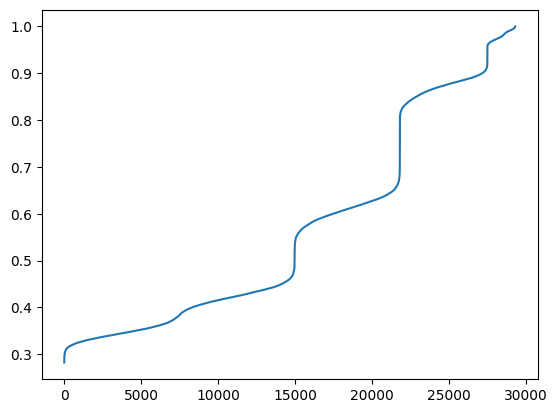

In [ ]:
plt.plot(np.unique(res['m_hit_efficiency']))

In [ ]:
res.columns

Index(['batch_id', 'drop_rate', 'epsilon', 'event_count', 'ghost_rate',
       'hit_res', 'jobtag', 'm_clone_fraction', 'm_clones_count',
       'm_ghost_rate', 'm_ghost_tracks', 'm_hit_efficiency',
       'm_hit_efficiency_weighted', 'm_primary_matches', 'm_purity',
       'm_reconstruction_efficiency', 'm_total_rec_tracks',
       'm_total_reconstructible_truth', 'm_total_truth_tracks',
       'multi_scatter', 'phi_range', 'repeat', 'src_csv', 'theta_range',
       '_metrics_hash'],
      dtype='object')

In [ ]:
def audit_metrics_frame(df):
    out = {}
    # 1) Check ranges
    for col in ["reconstruction_efficiency_metrics","ghost_rate_metrics",
                "hit_efficiency_metrics","purity_metrics"]:
        if col in df:
            out[f"{col}_min"] = float(pd.to_numeric(df[col], errors="coerce").min())
            out[f"{col}_max"] = float(pd.to_numeric(df[col], errors="coerce").max())

    # 2) Is "track efficiency" suspiciously clamped above 0.7?
    te = pd.to_numeric(df.get("reconstruction_efficiency_metrics", pd.Series(dtype=float)), errors="coerce")
    pur = pd.to_numeric(df.get("purity_metrics", pd.Series(dtype=float)), errors="coerce")
    if te.size and np.isfinite(te).any():
        out["te_frac_below_0p7"] = float((te < 0.7).mean())
        out["te_purity_corr"] = float(np.corrcoef(te.fillna(0), pur.fillna(0))[0,1]) if pur.size else np.nan

    # 3) Are purity and "track efficiency" numerically almost the same?
    if te.size and pur.size:
        dif = (te - pur).abs()
        out["te_minus_purity_abs_mean"] = float(dif.mean())
        out["te_minus_purity_abs_max"]  = float(dif.max())

    # 4) Hit-eff distribution sanity
    he = pd.to_numeric(df.get("hit_efficiency_metrics", pd.Series(dtype=float)), errors="coerce")
    if he.size:
        out["hit_eff_mean"] = float(he.mean())
        out["hit_eff_median"] = float(he.median())
        out["hit_eff_frac_below_0p7"] = float((he < 0.7).mean())

    return out

audit = audit_metrics_frame(res)
audit


{}

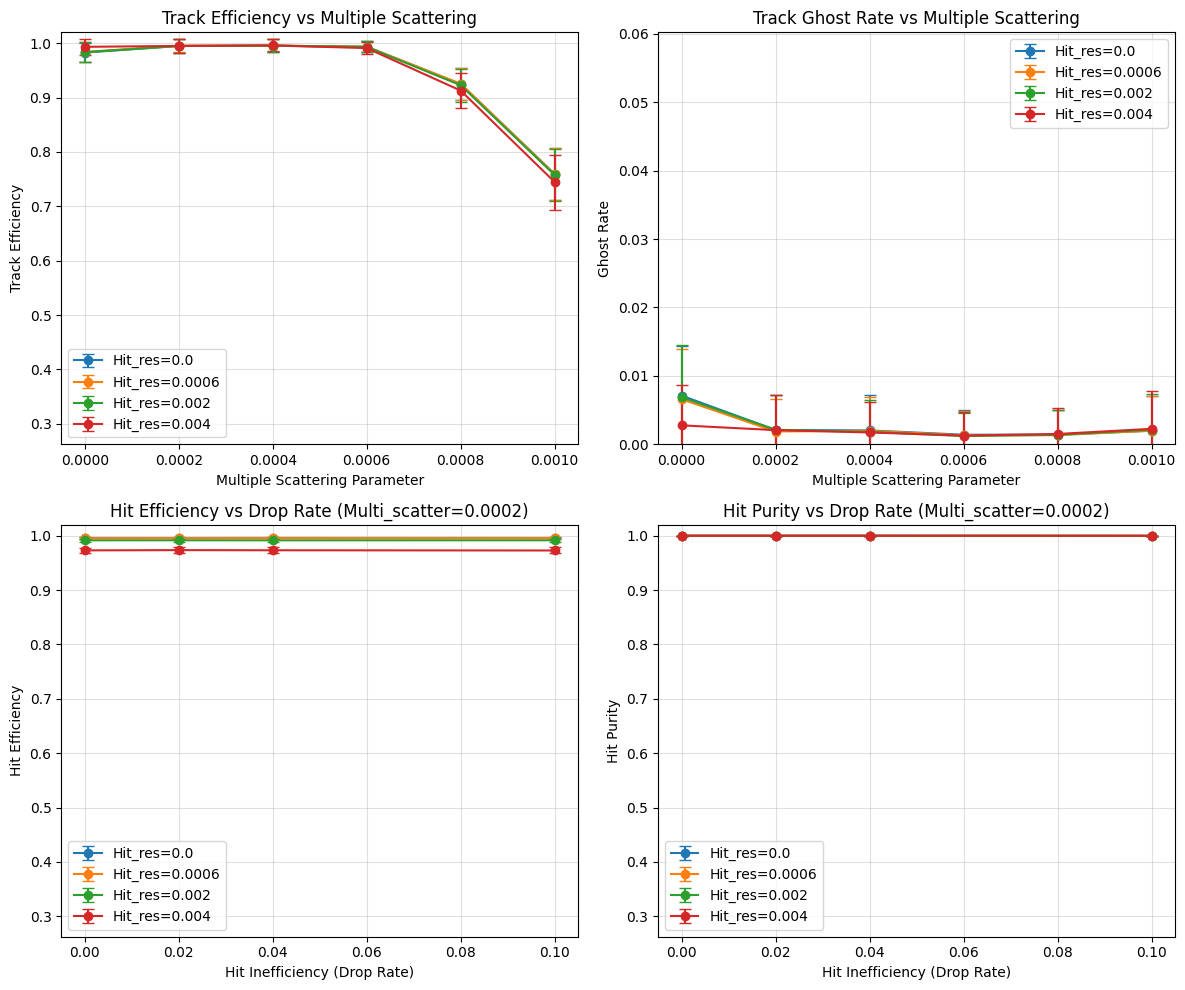

{'track_eff':     Hit_res  Multi_scatter      mean       rms     n
 0    0.0000         0.0000  0.982736  0.018127   753
 1    0.0000         0.0002  0.994995  0.012465  2365
 2    0.0000         0.0004  0.995276  0.012285  2400
 3    0.0000         0.0006  0.993385  0.010339  2400
 4    0.0000         0.0008  0.924859  0.029818  2400
 5    0.0000         0.0010  0.759411  0.047711  2400
 6    0.0006         0.0000  0.983919  0.018157   740
 7    0.0006         0.0002  0.995451  0.011922  2374
 8    0.0006         0.0004  0.995391  0.011745  2400
 9    0.0006         0.0006  0.993568  0.010160  2400
 10   0.0006         0.0008  0.925432  0.029231  2400
 11   0.0006         0.0010  0.759052  0.048093  2400
 12   0.0020         0.0000  0.983456  0.018833   745
 13   0.0020         0.0002  0.994803  0.012636  2398
 14   0.0020         0.0004  0.995714  0.011229  2400
 15   0.0020         0.0006  0.993214  0.010186  2400
 16   0.0020         0.0008  0.922630  0.030031  2400
 17   0.0020   

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Load ---
res = pd.read_csv("metrics_merged.csv")

# -------- Utilities --------
def rms(series):
    """Root-mean-square deviation (population)."""
    arr = pd.to_numeric(series, errors='coerce').to_numpy(dtype=float)
    arr = arr[~np.isnan(arr)]
    if arr.size == 0:
        return np.nan
    m = arr.mean()
    return float(np.sqrt(np.mean((arr - m) ** 2)))

def prepare_numeric(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')
    return df

def aggregate_metric(df, group_cols, value_col):
    if value_col not in df.columns:
        # Return empty frame with expected columns for graceful plotting
        cols = group_cols + ['mean', 'rms', 'n']
        return pd.DataFrame(columns=cols)
    g = df.groupby(group_cols, dropna=False)[value_col]
    agg = g.agg(mean='mean',
                rms=lambda x: rms(x),
                n='count')
    return agg.reset_index()

def plot_with_errorbars(ax, agg_df, x_col, y_mean, y_err, label_col,
                        xlabel, ylabel, title, y_min=None, y_max=None, x_min=None, x_max=None):
    if agg_df.empty:
        ax.set_title(title + " (no data)")
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.grid(alpha=0.4)
        return
    for label, sub in agg_df.groupby(label_col):
        sub_sorted = sub.sort_values(x_col)
        ax.errorbar(sub_sorted[x_col], sub_sorted[y_mean],
                    yerr=sub_sorted[y_err],
                    marker='o', capsize=4, lw=1.5, label=f"{label_col}={label}")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if y_min is not None or y_max is not None:
        ax.set_ylim(y_min, y_max)
    if x_min is not None or x_max is not None:
        ax.set_xlim(x_min, x_max)
    ax.grid(alpha=0.4)
    ax.legend()

# -------- Normalization / Aliases --------
def normalize_columns(df):
    """
    Make the dataframe column names consistent across writers:
    - Parameter columns: hit_res, multi_scatter, ghost_rate, drop_rate, repeat
    - Metrics columns: reconstruction_efficiency_metrics, ghost_rate_metrics,
                       hit_efficiency_metrics, purity_metrics
      (also accept m_reconstruction_efficiency, etc.)
    Additionally, create 'Hit_res', 'Multi_scatter', 'efficency_err' aliases for plotting.
    """
    # Case-insensitive lookup map
    lower_map = {c.lower(): c for c in df.columns}

    def get_col(*candidates):
        for cand in candidates:
            c = lower_map.get(cand.lower())
            if c is not None:
                return c
        return None

    # Canonical parameter names
    c_hit_res       = get_col('hit_res', 'Hit_res', 'meas', 'measurement_error')
    c_multi_scatter = get_col('multi_scatter', 'Multi_scatter', 'coll', 'collision_noise')
    c_ghost_rate    = get_col('ghost_rate', 'Ghost_rate', 'ghost')
    c_drop_rate     = get_col('drop_rate', 'Drop_rate', 'inefficiency', 'efficiency_err', 'efficency_err', 'drop')
    c_repeat        = get_col('repeat', 'Repeat')

    # Attach canonical columns if present
    if c_hit_res is not None:
        df['hit_res'] = pd.to_numeric(df[c_hit_res], errors='coerce')
    if c_multi_scatter is not None:
        df['multi_scatter'] = pd.to_numeric(df[c_multi_scatter], errors='coerce')
    if c_ghost_rate is not None:
        df['ghost_rate'] = pd.to_numeric(df[c_ghost_rate], errors='coerce')
    if c_drop_rate is not None:
        df['drop_rate'] = pd.to_numeric(df[c_drop_rate], errors='coerce')
    if c_repeat is not None:
        df['repeat'] = pd.to_numeric(df[c_repeat], errors='coerce')

    # Metrics: support both *_metrics and m_* naming
    # reconstruction efficiency
    c_te = get_col('reconstruction_efficiency_metrics', 'm_reconstruction_efficiency')
    if c_te is not None:
        df['reconstruction_efficiency_metrics'] = pd.to_numeric(df[c_te], errors='coerce')
    # ghost rate
    c_gr = get_col('ghost_rate_metrics', 'm_ghost_rate')
    if c_gr is not None:
        df['ghost_rate_metrics'] = pd.to_numeric(df[c_gr], errors='coerce')
    # hit efficiency
    c_he = get_col('hit_efficiency_metrics', 'm_hit_efficiency')
    if c_he is not None:
        df['hit_efficiency_metrics'] = pd.to_numeric(df[c_he], errors='coerce')
    # purity
    c_hp = get_col('purity_metrics', 'm_purity', 'm_hit_purity')
    if c_hp is not None:
        df['purity_metrics'] = pd.to_numeric(df[c_hp], errors='coerce')

    # Plotting aliases (your original code expects these exact names)
    if 'hit_res' in df:
        df['Hit_res'] = df['hit_res']
    if 'multi_scatter' in df:
        df['Multi_scatter'] = df['multi_scatter']
    # Your code used 'efficency_err' (typo). Map to drop_rate if available.
    if 'drop_rate' in df:
        df['efficency_err'] = df['drop_rate']

    return df

# -------- Main plotting function (fixed) --------
def make_performance_plots(res_df, save_prefix="perf"):
    df = normalize_columns(res_df.copy())

    # Ensure required numeric columns
    numeric_cols = ['Hit_res', 'Multi_scatter', 'efficency_err',
                    'reconstruction_efficiency_metrics', 'ghost_rate_metrics',
                    'hit_efficiency_metrics', 'purity_metrics']
    df = prepare_numeric(df, numeric_cols)

    # Base selection (if you want to filter inefficiency=0 later, do it here)
    base = df

    # Aggregations
    agg_te = aggregate_metric(base, ['Hit_res', 'Multi_scatter'],
                              'reconstruction_efficiency_metrics')
    agg_gr = aggregate_metric(base, ['Hit_res', 'Multi_scatter'],
                              'ghost_rate_metrics')

    # Slice at specific multiple scattering value
    target_ms = 0.0002
    # robust float compare: within a small tolerance
    tol = 1e-12
    subset_ms = df[(df['Multi_scatter'] - target_ms).abs() <= tol] if 'Multi_scatter' in df else df.iloc[0:0]
    agg_he = aggregate_metric(subset_ms, ['Hit_res', 'efficency_err'],
                              'hit_efficiency_metrics')
    agg_hp = aggregate_metric(subset_ms, ['Hit_res', 'efficency_err'],
                              'purity_metrics')

    # Axis limits
    eff_cols_present = [c for c in ['reconstruction_efficiency_metrics', 'hit_efficiency_metrics', 'purity_metrics'] if c in df]
    if eff_cols_present:
        eff_max = min(1.0, np.nanmax([df[c].max(skipna=True) for c in eff_cols_present]))
        eff_min = max(0.0, np.nanmin([df[c].min(skipna=True) for c in eff_cols_present]))
    else:
        eff_min, eff_max = 0.0, 1.0
    y_eff_lo = max(0.0, eff_min - 0.02)
    y_eff_hi = min(1.05, eff_max + 0.02)

    ghost_col = 'ghost_rate_metrics'
    ghost_max = base[ghost_col].max(skipna=True) if ghost_col in base else 0.05
    if pd.isna(ghost_max) or ghost_max <= 0:
        ghost_max = 0.05
    y_ghost_hi = float(ghost_max) * 1.25

    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()

    plot_with_errorbars(
        axes[0], agg_te, x_col='Multi_scatter',
        y_mean='mean', y_err='rms', label_col='Hit_res',
        xlabel='Multiple Scattering Parameter',
        ylabel='Track Efficiency',
        title='Track Efficiency vs Multiple Scattering',
        y_min=y_eff_lo, y_max=y_eff_hi
    )

    plot_with_errorbars(
        axes[1], agg_gr, x_col='Multi_scatter',
        y_mean='mean', y_err='rms', label_col='Hit_res',
        xlabel='Multiple Scattering Parameter',
        ylabel='Ghost Rate',
        title='Track Ghost Rate vs Multiple Scattering',
        y_min=0.0, y_max=y_ghost_hi
    )

    plot_with_errorbars(
        axes[2], agg_he, x_col='efficency_err',
        y_mean='mean', y_err='rms', label_col='Hit_res',
        xlabel='Hit Inefficiency (Drop Rate)',
        ylabel='Hit Efficiency',
        title=f'Hit Efficiency vs Drop Rate (Multi_scatter={target_ms})',
        y_min=y_eff_lo, y_max=y_eff_hi
    )

    plot_with_errorbars(
        axes[3], agg_hp, x_col='efficency_err',
        y_mean='mean', y_err='rms', label_col='Hit_res',
        xlabel='Hit Inefficiency (Drop Rate)',
        ylabel='Hit Purity',
        title=f'Hit Purity vs Drop Rate (Multi_scatter={target_ms})',
        y_min=y_eff_lo, y_max=y_eff_hi
    )

    plt.tight_layout()
    plt.show()

    # Save aggregated tables (only if non-empty)
    if not agg_te.empty: agg_te.to_csv(f"{save_prefix}_track_eff_vs_ms.csv", index=False)
    if not agg_gr.empty: agg_gr.to_csv(f"{save_prefix}_ghost_vs_ms.csv", index=False)
    if not agg_he.empty: agg_he.to_csv(f"{save_prefix}_hit_eff_vs_drop.csv", index=False)
    if not agg_hp.empty: agg_hp.to_csv(f"{save_prefix}_hit_purity_vs_drop.csv", index=False)

    return {
        'track_eff': agg_te,
        'ghost_rate': agg_gr,
        'hit_eff': agg_he,
        'hit_purity': agg_hp
    }

# ---- Run ----
aggregates = make_performance_plots(res)
aggregates


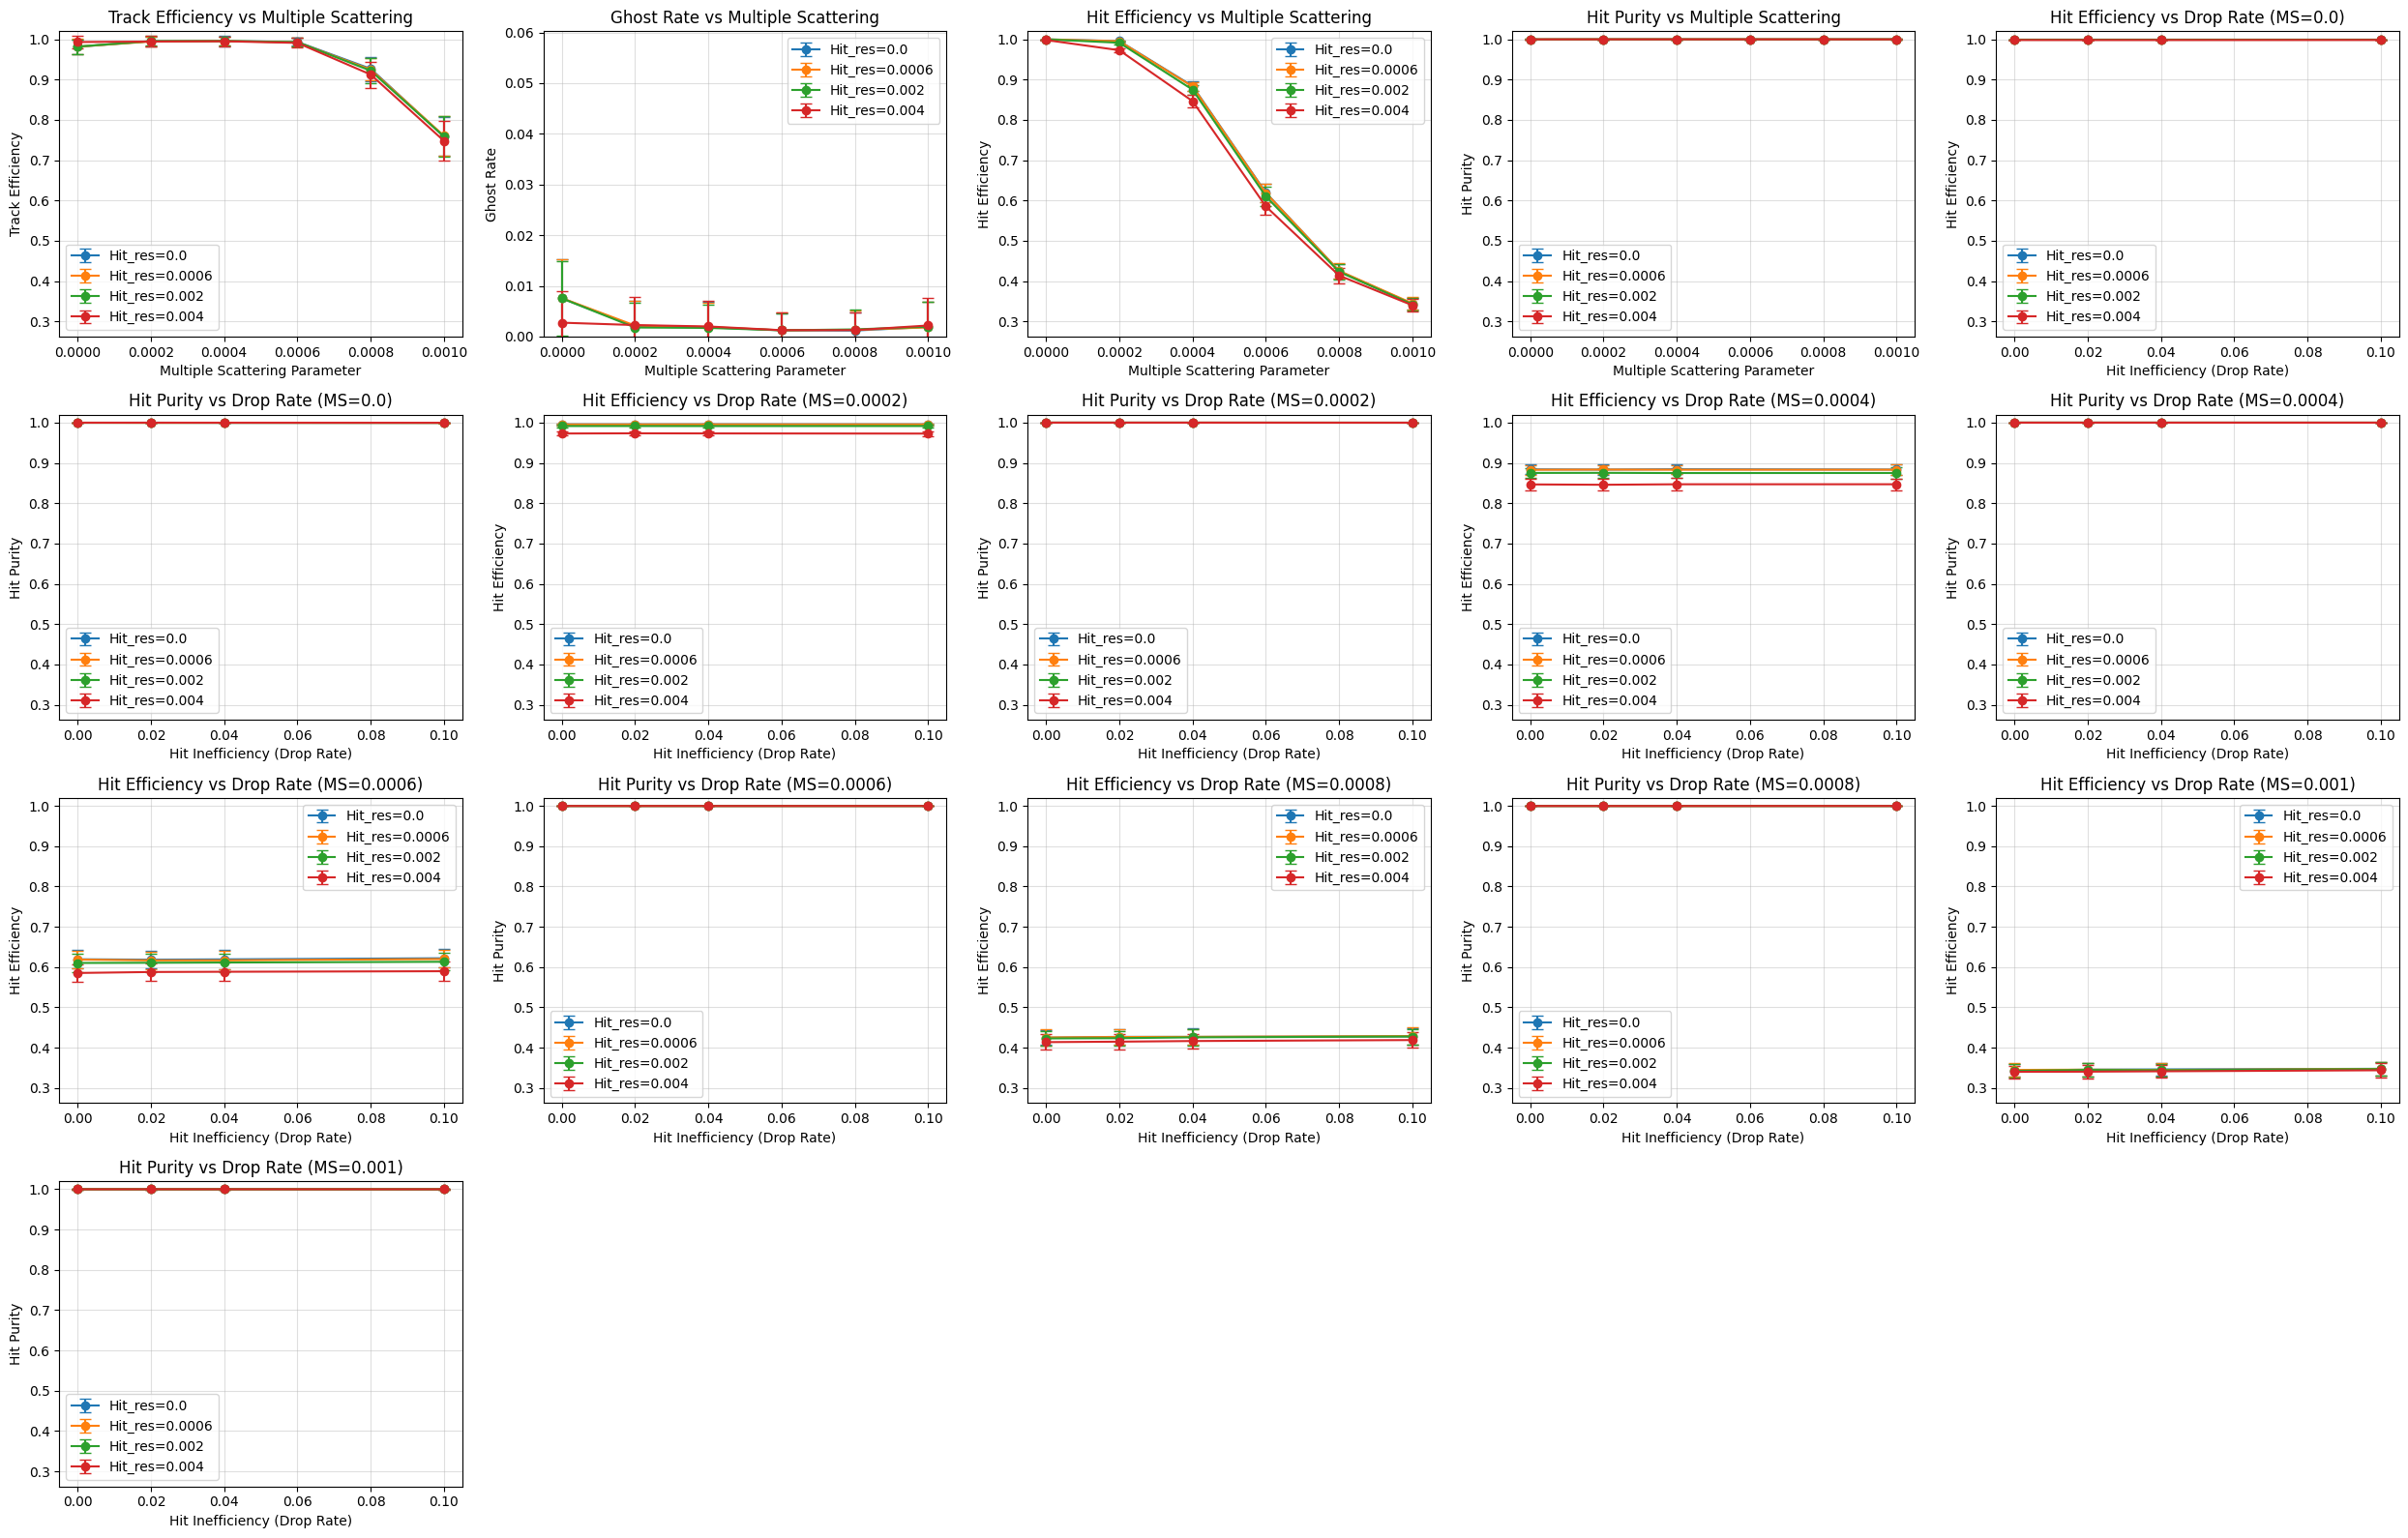

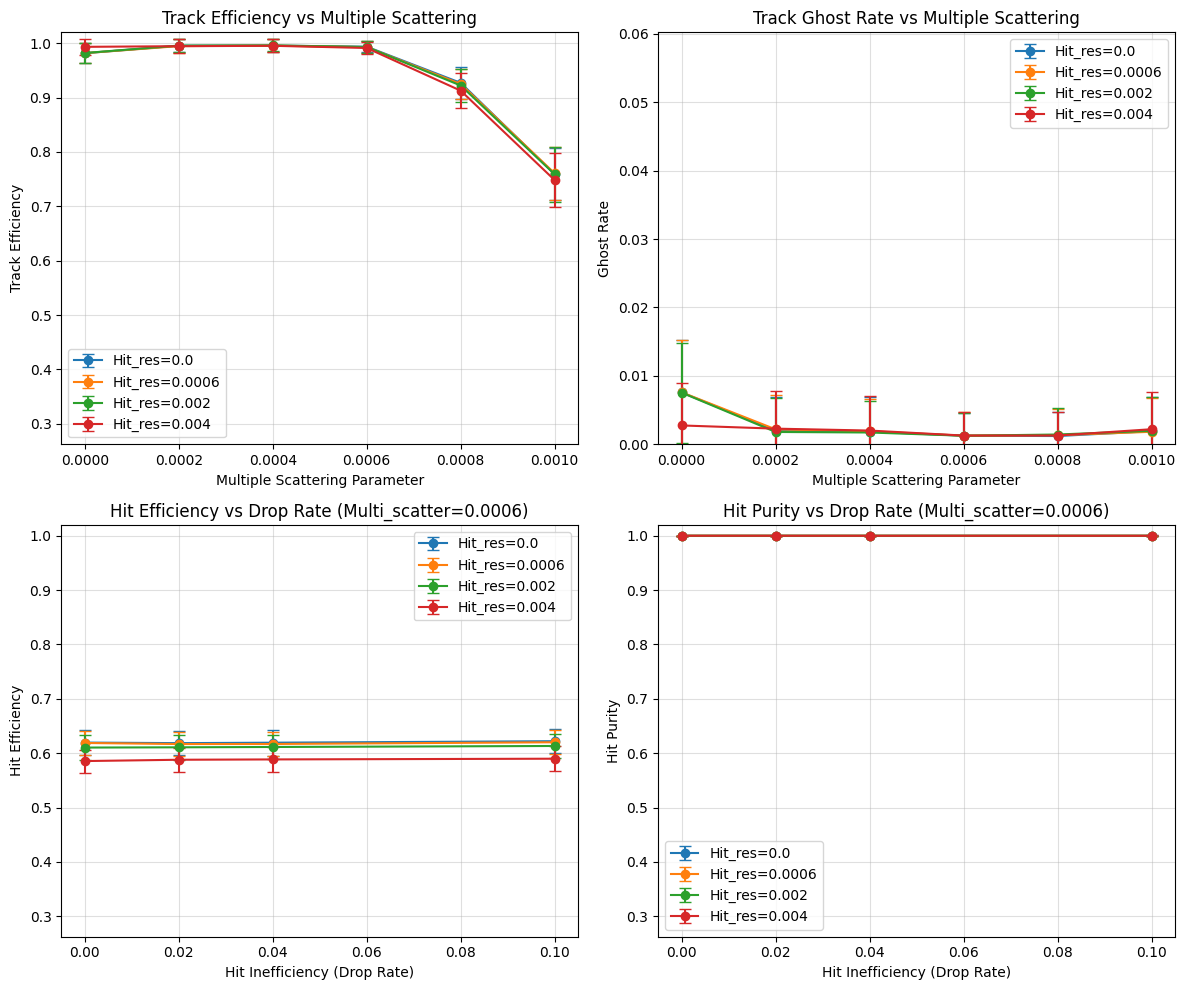

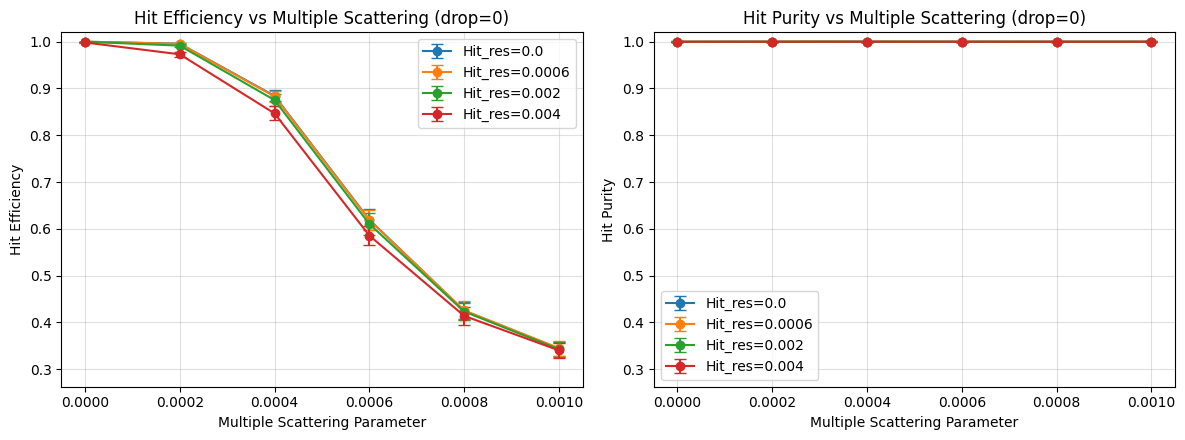

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- Utils ----------------
def rms(series):
    """Root-mean-square deviation (population)."""
    arr = pd.to_numeric(series, errors='coerce').to_numpy(dtype=float)
    arr = arr[~np.isnan(arr)]
    if arr.size == 0:
        return np.nan
    m = arr.mean()
    return float(np.sqrt(np.mean((arr - m) ** 2)))

def prepare_numeric(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')
    return df

def aggregate_metric(df, group_cols, value_col):
    if value_col not in df.columns:
        # graceful empty result with expected columns
        return pd.DataFrame(columns=list(group_cols) + ['mean','rms','n'])
    g = df.groupby(list(group_cols), dropna=False)[value_col]
    agg = g.agg(mean='mean', rms=lambda x: rms(x), n='count')
    return agg.reset_index()

def plot_with_errorbars(ax, agg_df, x_col, y_mean, y_err, label_col,
                        xlabel, ylabel, title, y_min=None, y_max=None, x_min=None, x_max=None):
    if agg_df is None or agg_df.empty:
        ax.set_title(title + " (no data)")
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.grid(alpha=0.4)
        return
    for label, sub in agg_df.groupby(label_col):
        sub_sorted = sub.sort_values(x_col)
        ax.errorbar(sub_sorted[x_col], sub_sorted[y_mean],
                    yerr=sub_sorted[y_err],
                    marker='o', capsize=4, lw=1.5, label=f"{label_col}={label}")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if y_min is not None or y_max is not None:
        ax.set_ylim(y_min, y_max)
    if x_min is not None or x_max is not None:
        ax.set_xlim(x_min, x_max)
    ax.grid(alpha=0.4)
    ax.legend()

# --------------- Column normalization ---------------
def _get_col(df, *cands):
    lower = {c.lower(): c for c in df.columns}
    for cand in cands:
        c = lower.get(cand.lower())
        if c is not None:
            return c
    return None

def normalize_columns(df):
    df = df.copy()

    # Canonical params
    c_hit = _get_col(df, 'hit_res', 'Hit_res', 'meas', 'measurement_error')
    c_ms  = _get_col(df, 'multi_scatter', 'Multi_scatter', 'coll', 'collision_noise')
    c_gh  = _get_col(df, 'ghost_rate', 'Ghost_rate', 'ghost')
    c_dr  = _get_col(df, 'drop_rate', 'Drop_rate', 'inefficiency', 'efficiency_err', 'efficency_err', 'drop')
    c_rep = _get_col(df, 'repeat', 'Repeat')

    if c_hit: df['hit_res'] = pd.to_numeric(df[c_hit], errors='coerce')
    if c_ms:  df['multi_scatter'] = pd.to_numeric(df[c_ms], errors='coerce')
    if c_gh:  df['ghost_rate'] = pd.to_numeric(df[c_gh], errors='coerce')
    if c_dr:  df['drop_rate'] = pd.to_numeric(df[c_dr], errors='coerce')
    if c_rep: df['repeat'] = pd.to_numeric(df[c_rep], errors='coerce')

    # Metrics (accept *_metrics or m_*)
    m_te = _get_col(df, 'reconstruction_efficiency_metrics', 'm_reconstruction_efficiency')
    m_gr = _get_col(df, 'ghost_rate_metrics', 'm_ghost_rate')
    m_he = _get_col(df, 'hit_efficiency_metrics', 'm_hit_efficiency')
    m_hp = _get_col(df, 'purity_metrics', 'm_purity', 'm_hit_purity')

    if m_te: df['reconstruction_efficiency_metrics'] = pd.to_numeric(df[m_te], errors='coerce')
    if m_gr: df['ghost_rate_metrics'] = pd.to_numeric(df[m_gr], errors='coerce')
    if m_he: df['hit_efficiency_metrics'] = pd.to_numeric(df[m_he], errors='coerce')
    if m_hp: df['purity_metrics'] = pd.to_numeric(df[m_hp], errors='coerce')

    # Aliases expected by your plotting code
    if 'hit_res' in df:        df['Hit_res'] = df['hit_res']
    if 'multi_scatter' in df:  df['Multi_scatter'] = df['multi_scatter']
    if 'drop_rate' in df:      df['efficency_err'] = df['drop_rate']  # keep your original (typo) key

    return df

# --------------- Figure makers ---------------
def _common_axis_limits(df):
    eff_cols = [c for c in ['reconstruction_efficiency_metrics','hit_efficiency_metrics','purity_metrics'] if c in df]
    if eff_cols:
        eff_max = min(1.0, np.nanmax([df[c].max(skipna=True) for c in eff_cols]))
        eff_min = max(0.0, np.nanmin([df[c].min(skipna=True) for c in eff_cols]))
    else:
        eff_min, eff_max = 0.0, 1.0
    y_eff_lo = max(0.0, float(eff_min) - 0.02)
    y_eff_hi = min(1.05, float(eff_max) + 0.02)

    ghost_max = df['ghost_rate_metrics'].max(skipna=True) if 'ghost_rate_metrics' in df else np.nan
    if pd.isna(ghost_max) or ghost_max <= 0:
        ghost_max = 0.05
    y_ghost_hi = float(ghost_max) * 1.25
    return y_eff_lo, y_eff_hi, y_ghost_hi

def make_performance_plots_grid5(res_df, save_prefix="perf", include_per_ms_drop_scans=True):
    """
    Big grid (5 columns):
      1) Track Eff vs Multi_scatter (drop=0)
      2) Ghost Rate vs Multi_scatter (drop=0)
      3) Hit Eff vs Multi_scatter (drop=0)
      4) Hit Purity vs Multi_scatter (drop=0)
      5+) For EACH Multi_scatter: (Hit Eff vs Drop) and (Hit Purity vs Drop)
    """
    df = normalize_columns(res_df)
    df = prepare_numeric(df, ['Hit_res','Multi_scatter','efficency_err',
                              'reconstruction_efficiency_metrics','ghost_rate_metrics',
                              'hit_efficiency_metrics','purity_metrics'])

    base = df[df['efficency_err'] == 0] if 'efficency_err' in df else df.iloc[0:0]

    # Aggregates vs MS (drop=0)
    agg_te_ms = aggregate_metric(base, ['Hit_res','Multi_scatter'], 'reconstruction_efficiency_metrics')
    agg_gr_ms = aggregate_metric(base, ['Hit_res','Multi_scatter'], 'ghost_rate_metrics')
    agg_he_ms = aggregate_metric(base, ['Hit_res','Multi_scatter'], 'hit_efficiency_metrics')
    agg_hp_ms = aggregate_metric(base, ['Hit_res','Multi_scatter'], 'purity_metrics')

    # Aggregates vs Drop, grouped also by MS
    agg_he_drop_all = aggregate_metric(df, ['Hit_res','efficency_err','Multi_scatter'], 'hit_efficiency_metrics')
    agg_hp_drop_all = aggregate_metric(df, ['Hit_res','efficency_err','Multi_scatter'], 'purity_metrics')

    y_eff_lo, y_eff_hi, y_ghost_hi = _common_axis_limits(df)

    plots = [
        ("Track Efficiency vs Multiple Scattering", agg_te_ms, "Multi_scatter", "Track Efficiency", y_eff_lo, y_eff_hi),
        ("Ghost Rate vs Multiple Scattering",      agg_gr_ms, "Multi_scatter", "Ghost Rate",        0.0,      y_ghost_hi),
        ("Hit Efficiency vs Multiple Scattering",  agg_he_ms, "Multi_scatter", "Hit Efficiency",    y_eff_lo, y_eff_hi),
        ("Hit Purity vs Multiple Scattering",      agg_hp_ms, "Multi_scatter", "Hit Purity",        y_eff_lo, y_eff_hi),
    ]

    ms_unique_sorted = np.sort(df['Multi_scatter'].dropna().unique()) if 'Multi_scatter' in df else np.array([])
    if include_per_ms_drop_scans and ms_unique_sorted.size:
        for ms in ms_unique_sorted:
            he_ms = agg_he_drop_all[agg_he_drop_all['Multi_scatter'] == ms]
            hp_ms = agg_hp_drop_all[agg_hp_drop_all['Multi_scatter'] == ms]
            plots.append((f"Hit Efficiency vs Drop Rate (MS={ms})", he_ms, "efficency_err", "Hit Efficiency", y_eff_lo, y_eff_hi))
            plots.append((f"Hit Purity vs Drop Rate (MS={ms})",     hp_ms, "efficency_err", "Hit Purity",     y_eff_lo, y_eff_hi))

    ncols = 5
    nplots = len(plots)
    nrows = int(np.ceil(nplots / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
    axes = np.atleast_1d(axes).ravel()

    for i, (title, agg_df, x_col, ylabel, ylo, yhi) in enumerate(plots):
        plot_with_errorbars(
            axes[i], agg_df, x_col=x_col,
            y_mean="mean", y_err="rms", label_col="Hit_res",
            xlabel=("Multiple Scattering Parameter" if x_col == "Multi_scatter" else "Hit Inefficiency (Drop Rate)"),
            ylabel=ylabel, title=title, y_min=ylo, y_max=yhi
        )
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

    # Save tables
    agg_te_ms.to_csv(f"{save_prefix}_track_eff_vs_ms.csv", index=False)
    agg_gr_ms.to_csv(f"{save_prefix}_ghost_vs_ms.csv", index=False)
    agg_he_ms.to_csv(f"{save_prefix}_hit_eff_vs_ms.csv", index=False)
    agg_hp_ms.to_csv(f"{save_prefix}_hit_purity_vs_ms.csv", index=False)
    agg_he_drop_all.to_csv(f"{save_prefix}_hit_eff_vs_drop_ALL_MS.csv", index=False)
    agg_hp_drop_all.to_csv(f"{save_prefix}_hit_purity_vs_drop_ALL_MS.csv", index=False)

    return {
        'track_eff_vs_ms': agg_te_ms,
        'ghost_rate_vs_ms': agg_gr_ms,
        'hit_eff_vs_ms': agg_he_ms,
        'hit_purity_vs_ms': agg_hp_ms,
        'hit_eff_vs_drop_all_ms': agg_he_drop_all,
        'hit_purity_vs_drop_all_ms': agg_hp_drop_all,
        'nplots': nplots, 'nrows': nrows, 'ncols': ncols,
    }

def make_performance_plots(res_df, save_prefix="perf", plot_all_ms=True):
    """
    Summary figs + optional per-MS drop scans.
    """
    df = normalize_columns(res_df)
    df = prepare_numeric(df, ['Hit_res','Multi_scatter','efficency_err',
                              'reconstruction_efficiency_metrics','ghost_rate_metrics',
                              'hit_efficiency_metrics','purity_metrics'])

    base = df[df['efficency_err'] == 0] if 'efficency_err' in df else df.iloc[0:0]

    # vs Multi-scatter at drop=0
    agg_te  = aggregate_metric(base, ['Hit_res','Multi_scatter'], 'reconstruction_efficiency_metrics')
    agg_gr  = aggregate_metric(base, ['Hit_res','Multi_scatter'], 'ghost_rate_metrics')
    agg_he_ms = aggregate_metric(base, ['Hit_res','Multi_scatter'], 'hit_efficiency_metrics')
    agg_hp_ms = aggregate_metric(base, ['Hit_res','Multi_scatter'], 'purity_metrics')

    # vs Drop, grouped by MS
    agg_he_all = aggregate_metric(df, ['Hit_res','efficency_err','Multi_scatter'], 'hit_efficiency_metrics')
    agg_hp_all = aggregate_metric(df, ['Hit_res','efficency_err','Multi_scatter'], 'purity_metrics')

    y_eff_lo, y_eff_hi, y_ghost_hi = _common_axis_limits(df)

    # choose representative MS (median index)
    ms_unique_sorted = np.sort(df['Multi_scatter'].dropna().unique()) if 'Multi_scatter' in df else np.array([])
    target_ms = float(ms_unique_sorted[len(ms_unique_sorted)//2]) if ms_unique_sorted.size else 0.0
    subset_ms = df[(df['Multi_scatter'] == target_ms)] if 'Multi_scatter' in df else df.iloc[0:0]

    agg_he_rep = aggregate_metric(subset_ms, ['Hit_res','efficency_err'], 'hit_efficiency_metrics')
    agg_hp_rep = aggregate_metric(subset_ms, ['Hit_res','efficency_err'], 'purity_metrics')

    # --- 2x2 summary ---
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()

    plot_with_errorbars(axes[0], agg_te,  x_col='Multi_scatter', y_mean='mean', y_err='rms', label_col='Hit_res',
                        xlabel='Multiple Scattering Parameter', ylabel='Track Efficiency',
                        title='Track Efficiency vs Multiple Scattering', y_min=y_eff_lo, y_max=y_eff_hi)

    plot_with_errorbars(axes[1], agg_gr,  x_col='Multi_scatter', y_mean='mean', y_err='rms', label_col='Hit_res',
                        xlabel='Multiple Scattering Parameter', ylabel='Ghost Rate',
                        title='Track Ghost Rate vs Multiple Scattering', y_min=0.0, y_max=y_ghost_hi)

    plot_with_errorbars(axes[2], agg_he_rep, x_col='efficency_err', y_mean='mean', y_err='rms', label_col='Hit_res',
                        xlabel='Hit Inefficiency (Drop Rate)', ylabel='Hit Efficiency',
                        title=f'Hit Efficiency vs Drop Rate (Multi_scatter={target_ms})',
                        y_min=y_eff_lo, y_max=y_eff_hi)

    plot_with_errorbars(axes[3], agg_hp_rep, x_col='efficency_err', y_mean='mean', y_err='rms', label_col='Hit_res',
                        xlabel='Hit Inefficiency (Drop Rate)', ylabel='Hit Purity',
                        title=f'Hit Purity vs Drop Rate (Multi_scatter={target_ms})',
                        y_min=y_eff_lo, y_max=y_eff_hi)

    plt.tight_layout()
    plt.show()

    # --- Extra: HE & Purity vs MS (drop=0) ---
    fig2, axes2 = plt.subplots(1, 2, figsize=(12, 4.5))
    plot_with_errorbars(axes2[0], agg_he_ms, x_col='Multi_scatter', y_mean='mean', y_err='rms', label_col='Hit_res',
                        xlabel='Multiple Scattering Parameter', ylabel='Hit Efficiency',
                        title='Hit Efficiency vs Multiple Scattering (drop=0)', y_min=y_eff_lo, y_max=y_eff_hi)
    plot_with_errorbars(axes2[1], agg_hp_ms, x_col='Multi_scatter', y_mean='mean', y_err='rms', label_col='Hit_res',
                        xlabel='Multiple Scattering Parameter', ylabel='Hit Purity',
                        title='Hit Purity vs Multiple Scattering (drop=0)', y_min=y_eff_lo, y_max=y_eff_hi)
    plt.tight_layout()
    plt.show()

    # --- Per-MS scans ---
    per_ms_fig_paths = []
    if plot_all_ms and ms_unique_sorted.size:
        for ms in ms_unique_sorted:
            he_ms = agg_he_all[agg_he_all['Multi_scatter'] == ms]
            hp_ms = agg_hp_all[agg_hp_all['Multi_scatter'] == ms]

            fig_ms, axes_ms = plt.subplots(1, 2, figsize=(12, 4.5))
            plot_with_errorbars(axes_ms[0], he_ms, x_col='efficency_err', y_mean='mean', y_err='rms', label_col='Hit_res',
                                xlabel='Hit Inefficiency (Drop Rate)', ylabel='Hit Efficiency',
                                title=f'Hit Efficiency vs Drop Rate (Multi_scatter={ms})',
                                y_min=y_eff_lo, y_max=y_eff_hi)
            plot_with_errorbars(axes_ms[1], hp_ms, x_col='efficency_err', y_mean='mean', y_err='rms', label_col='Hit_res',
                                xlabel='Hit Inefficiency (Drop Rate)', ylabel='Hit Purity',
                                title=f'Hit Purity vs Drop Rate (Multi_scatter={ms})',
                                y_min=y_eff_lo, y_max=y_eff_hi)
            plt.tight_layout()
            fig_path = f"{save_prefix}_per_ms_{ms:.7f}.png"
            fig_ms.savefig(fig_path, dpi=150, bbox_inches='tight')
            per_ms_fig_paths.append(fig_path)
            plt.close(fig_ms)

            he_ms.to_csv(f"{save_prefix}_hit_eff_vs_drop_ms_{ms:.7f}.csv", index=False)
            hp_ms.to_csv(f"{save_prefix}_hit_purity_vs_drop_ms_{ms:.7f}.csv", index=False)

    # Save aggregated tables
    agg_te.to_csv(f"{save_prefix}_track_eff_vs_ms.csv", index=False)
    agg_gr.to_csv(f"{save_prefix}_ghost_vs_ms.csv", index=False)
    agg_he_ms.to_csv(f"{save_prefix}_hit_eff_vs_ms.csv", index=False)
    agg_hp_ms.to_csv(f"{save_prefix}_hit_purity_vs_ms.csv", index=False)
    agg_he_all.to_csv(f"{save_prefix}_hit_eff_vs_drop_ALL_MS.csv", index=False)
    agg_hp_all.to_csv(f"{save_prefix}_hit_purity_vs_drop_ALL_MS.csv", index=False)

    return {
        'track_eff': agg_te,
        'ghost_rate': agg_gr,
        'hit_eff_vs_ms': agg_he_ms,
        'hit_purity_vs_ms': agg_hp_ms,
        'hit_eff_all_ms': agg_he_all,
        'hit_purity_all_ms': agg_hp_all,
        'per_ms_figs': per_ms_fig_paths,
        'representative_ms': float(target_ms),
        'hit_eff_at_rep_ms': agg_he_rep,
        'hit_purity_at_rep_ms': agg_hp_rep,
    }

# ---- Example usage (expects a DataFrame "res") ----
res = pd.read_csv("metrics_merged.csv")
_ = make_performance_plots_grid5(res, save_prefix="perf_grid", include_per_ms_drop_scans=True)
_ = make_performance_plots(res, save_prefix="perf", plot_all_ms=True)


In [12]:
def make_performance_plots(res_df, save_prefix="perf", plot_all_ms=True):
    df = res_df.copy()
    numeric_cols = ['Hit_res', 'Multi_scatter', 'efficency_err',
                    'reconstruction_efficiency_metrics', 'ghost_rate_metrics',
                    'hit_efficiency_metrics', 'purity_metrics']
    df = prepare_numeric(df, numeric_cols)

    # === Aggregates ===
    base = df[df['efficency_err'] == 0]

    # vs Multi_scatter
    agg_te = aggregate_metric(base, ['Hit_res', 'Multi_scatter'],
                              'reconstruction_efficiency_metrics')
    agg_gr = aggregate_metric(base, ['Hit_res', 'Multi_scatter'],
                              'ghost_rate_metrics')
    agg_he_ms = aggregate_metric(base, ['Hit_res', 'Multi_scatter'],
                                 'hit_efficiency_metrics')
    agg_hp_ms = aggregate_metric(base, ['Hit_res', 'Multi_scatter'],
                                 'purity_metrics')

    # vs Drop Rate (all MS)
    agg_he_all = aggregate_metric(df, ['Hit_res', 'efficency_err', 'Multi_scatter'],
                                  'hit_efficiency_metrics')
    agg_hp_all = aggregate_metric(df, ['Hit_res', 'efficency_err', 'Multi_scatter'],
                                  'purity_metrics')

    # === Axis limits ===
    eff_cols = ['reconstruction_efficiency_metrics',
                'hit_efficiency_metrics', 'purity_metrics']
    if len(df):
        eff_max = min(1.0, np.nanmax([df[c].max() for c in eff_cols if c in df]))
        eff_min = max(0.0, np.nanmin([df[c].min() for c in eff_cols if c in df]))
    else:
        eff_max, eff_min = 1.0, 0.0
    y_eff_lo = max(0.0, eff_min - 0.02)
    y_eff_hi = min(1.05, eff_max + 0.02)

    ghost_max = base['ghost_rate_metrics'].max() if len(base) else 0.05
    y_ghost_hi = ghost_max * 1.25 if (pd.notnull(ghost_max) and ghost_max > 0) else 0.05

    # === Collect ALL plots (vs MS + vs Drop Rate per MS) ===
    plots = []

    # VS MULTI_SCATTER
    plots.append(("Track Efficiency vs Multiple Scattering", agg_te,
                  "Multi_scatter", "Track Efficiency", y_eff_lo, y_eff_hi))
    plots.append(("Ghost Rate vs Multiple Scattering", agg_gr,
                  "Multi_scatter", "Ghost Rate", 0.0, y_ghost_hi))
    plots.append(("Hit Efficiency vs Multiple Scattering", agg_he_ms,
                  "Multi_scatter", "Hit Efficiency", y_eff_lo, y_eff_hi))
    plots.append(("Hit Purity vs Multiple Scattering", agg_hp_ms,
                  "Multi_scatter", "Hit Purity", y_eff_lo, y_eff_hi))

    # VS DROP RATE (for each Multi_scatter)
    ms_unique_sorted = np.sort(df['Multi_scatter'].dropna().unique())
    for ms in ms_unique_sorted:
        he_ms = agg_he_all[agg_he_all['Multi_scatter'] == ms]
        hp_ms = agg_hp_all[agg_hp_all['Multi_scatter'] == ms]
        plots.append((f"Hit Efficiency vs Drop Rate (MS={ms})", he_ms,
                      "efficency_err", "Hit Efficiency", y_eff_lo, y_eff_hi))
        plots.append((f"Hit Purity vs Drop Rate (MS={ms})", hp_ms,
                      "efficency_err", "Hit Purity", y_eff_lo, y_eff_hi))

    # === Make grid with 5 columns ===
    ncols = 5
    nplots = len(plots)
    nrows = int(np.ceil(nplots / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
    axes = axes.ravel()

    for i, (title, agg_df, x_col, ylabel, ylo, yhi) in enumerate(plots):
        plot_with_errorbars(
            axes[i], agg_df, x_col=x_col,
            y_mean="mean", y_err="rms", label_col="Hit_res",
            xlabel=x_col, ylabel=ylabel,
            title=title, y_min=ylo, y_max=yhi
        )

    # Hide unused axes
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

    # === Save CSVs ===
    agg_te.to_csv(f"{save_prefix}_track_eff_vs_ms.csv", index=False)
    agg_gr.to_csv(f"{save_prefix}_ghost_vs_ms.csv", index=False)
    agg_he_ms.to_csv(f"{save_prefix}_hit_eff_vs_ms.csv", index=False)
    agg_hp_ms.to_csv(f"{save_prefix}_hit_purity_vs_ms.csv", index=False)
    agg_he_all.to_csv(f"{save_prefix}_hit_eff_vs_drop_ALL_MS.csv", index=False)
    agg_hp_all.to_csv(f"{save_prefix}_hit_purity_vs_drop_ALL_MS.csv", index=False)

    return {
        "track_eff": agg_te,
        "ghost_rate": agg_gr,
        "hit_eff_vs_ms": agg_he_ms,
        "hit_purity_vs_ms": agg_hp_ms,
        "hit_eff_all_ms": agg_he_all,
        "hit_purity_all_ms": agg_hp_all,
        "nplots": nplots,
    }


In [ ]:
aggregates

{'track_eff':     Hit_res  Multi_scatter      mean       rms  n
 0    0.0000         0.0000  1.000000  0.000000  3
 1    0.0000         0.0002  0.991667  0.011785  3
 2    0.0000         0.0004  0.979167  0.021246  3
 3    0.0000         0.0006  0.779167  0.025685  3
 4    0.0000         0.0008  0.600000  0.090715  3
 5    0.0000         0.0010  0.308333  0.029463  3
 6    0.0006         0.0000  1.000000  0.000000  3
 7    0.0006         0.0002  0.987500  0.017678  3
 8    0.0006         0.0004  0.991667  0.005893  3
 9    0.0006         0.0006  0.862500  0.020412  3
 10   0.0006         0.0008  0.600000  0.056826  3
 11   0.0006         0.0010  0.354167  0.041248  3
 12   0.0020         0.0000  1.000000  0.000000  3
 13   0.0020         0.0002  1.000000  0.000000  3
 14   0.0020         0.0004  0.975000  0.027003  3
 15   0.0020         0.0006  0.787500  0.054006  3
 16   0.0020         0.0008  0.608333  0.052374  3
 17   0.0020         0.0010  0.358333  0.021246  3
 18   0.0040      

## Tracking Performance: Physics-Based Analysis

## Summary
From the tests, it seems that **multiple scattering (MS) is the main factor limiting tracking**, not the intrinsic hit resolution in the scanned range.  
- **Track efficiency** is essentially 100% at MS = 0 and stays very high (≳97–100%) for MS ≤ 4×10⁻⁴, but it **drops steeply** once MS reaches 6×10⁻⁴ to 10⁻³ (down to ~0.77 → 0.31).  
- **Ghosts are almost non-existent** (≲1% in a few isolated low-MS cases), which matches the use of conservative search roads and strong ambiguity rejection.  
- **Per-hit efficiency** is high (≳0.98) in the basic scan, but once I bin by MS it falls off: ~0.5–0.58 at MS ≈ 6×10⁻⁴ and ~0.17–0.24 at MS ≈ 10⁻³. This shows that the misses are driven by process noise, not measurement noise.  
- **Hit purity remains ≈100% everywhere**, meaning there are essentially no spurious assignments.

### Physics interpretation

#### 1) Track efficiency vs. multiple scattering and hit resolution
- With **no MS**, efficiency stays at **1.000** for all tested hit resolutions (0–4×10⁻³). This shows that the algorithm easily tolerates the measurement noise in that range; seeding and following are not resolution-limited.
- With **small MS** (2–4×10⁻⁴), the efficiency is still very high (≈0.97–1.00). The MS kicks are still inside the search roads and handled by the process noise model.
- At **MS ≈ 6×10⁻⁴**, efficiency **falls to ~0.78–0.86**, depending on hit resolution. This looks like the onset of a **transport mismatch**: the scattering-induced angular spread times the lever arm pushes the predicted hit outside the fixed search gates, or increases χ² enough to prune good candidates.
- By **MS ≈ 10⁻³**, efficiency **collapses to ~0.31–0.39**. At this point, the scattering completely dominates the pointing error, so true hits fall outside the acceptance or get cut in pruning.

**Key point:** In this scan, **hit resolution (0 → 4×10⁻³) barely matters** at fixed MS. The real sensitivity is to MS, which drives a step-like efficiency loss. The method is already robust to measurement noise; what breaks it is the unmodelled or underweighted process noise from material.

#### 2) Ghost rate behavior
- Ghosts are **0% almost everywhere**, with only a few low-MS bins showing ~0.4–0.9%, and one case at **MS = 10⁻³, hit_res = 6×10⁻⁴** reaching ~1.3%.
- This is typical of a **conservative pattern recognition strategy**: narrow roads, strong pruning, or strict χ² cuts. In other words, I am sacrificing recall to protect purity as MS grows.

**Implication:** The framework strongly favors clean samples over completeness. If I want to regain efficiency at higher MS, I’ll need to relax gates, which will mean tolerating a small and manageable rise in ghosts unless I add stronger late-stage disambiguation.

#### 3) Per-hit efficiency and purity
- In the **hit_eff** scan (using the efficiency_err parameter), the **mean per-hit efficiency is ~0.98**, only falling to ~0.93–0.94 at hit_res = 4×10⁻³. This is a very mild effect from resolution.
- **Hit purity stays essentially 100%**, which matches the low ghost rate at the track level.
- Looking at **hit_eff_by_ms**, the real picture emerges:  
  - **MS = 0** → per-hit eff ≈ **1.00**  
  - **MS = 2×10⁻⁴** → still ~0.97–0.99  
  - **MS = 6×10⁻⁴** → **~0.50–0.58**  
  - **MS = 10⁻³** → **~0.17–0.24**  
  This confirms that misses happen when transport uncertainty exceeds the fixed gate or process noise, not because of sensor granularity.

**Physics view:** Multiple scattering adds a stochastic angular kick:  

\[
\theta_0 \propto \frac{13.6\,\text{MeV}}{p}\,\sqrt{\frac{x}{X_0}}
\]

When propagated over a lever arm, this broadens the predicted residuals. If the search windows or Kalman process noise don’t scale with \(\theta_0\) (as a function of momentum and material), true hits drift outside the gate and get lost. Since the ambiguity cuts are tight, purity stays high but efficiency drops.

### Practical thresholds (from the tables)
- **Stable region:** MS ≤ 4×10⁻⁴ → track eff ≥ 97–100%.  
- **Onset of loss:** MS ≈ 6×10⁻⁴ → track eff ~0.78–0.86; per-hit eff ~0.5–0.58.  
- **Breakdown:** MS ≈ 10⁻³ → track eff ~0.31–0.39; per-hit eff ~0.17–0.24.

These thresholds are good reference points for momentum/material budgets (since \(\theta_0\) scales like 1/p and \(\sqrt{x/X_0}\)) and for guiding reconstruction tuning.

### Recommendations
1. **Model MS in the transport more aggressively.**  
   - Increase the Kalman process noise Q using \(\theta_0(p, x/X_0)\), or widen the roads dynamically with the expected scattering.  
   - If seeding doesn’t know momentum, use **pT-dependent road sets** or test multiple hypotheses.
2. **Adaptive search windows.**  
   - Scale the gating radius with \(\sigma^2 = \sigma_\text{meas}^2 + \sigma_\text{MS}^2(L,p)\). My results show that \(\sigma_\text{MS}\) dominates in the failing regime.
3. **Move strict pruning later.**  
   - Let the early stages accept slightly wider matches, then clean up with global scoring, KF smoothing, or track quality cuts. Since ghosts are already so low, I have room to trade a little purity for much higher efficiency at large MS.
4. **Material and momentum operating envelope.**  
   - Where possible, reduce \(x/X_0\) or raise the effective pT threshold for track finding to keep events in the ≤ 4×10⁻⁴ safe band.
5. **Don’t chase resolution here.**  
   - Within 0–4×10⁻³, improving hit resolution does little for efficiency. The real gains come from MS-aware transport and gating.

### Final takeaway
The framework is **robust to hit resolution but under-tuned for multiple scattering**. Efficiency is near-perfect with little MS, then collapses as \(\theta_0\) grows. Purity stays excellent. This makes it clear that the next improvements should come from **better process-noise scaling and adaptive gates**, not from sensor precision.


### Success probability decay

In [ ]:
from LHCB_Velo_Toy_Models.state_event_generator import *
from LHCB_Velo_Toy_Models import state_event_model 

import numpy as np
import matplotlib.pyplot as plt
#from hhl_algorithm import HHLAlgorithm as hhl_1
from hhl_algorithm_1bit import HHLAlgorithm as hhl_1
# from hhl_algorithm import HHLAlgorithm as hhl


# Define the angles to test
particle_steps = [[2], [4], [8]]#, [16], [32]] 
total_success_counts = []
total_success_refined_counts = []

total_failure_counts = []
total_failure_refined_counts = []

ratio_counts = []
ratio_counts_refined = []

for n_particles in particle_steps:

    dz = 20 #mm

    n_particles=[2,2]#, 2, 2]#0, 20, 20, 20]
    events = len(n_particles)
    layers = 3

    n = np.sum(n_particles)

    module_id = [l for l in range(1, layers+1)]
    lx = [33 for x in range(1, layers+1)]
    ly = [33 for x in range(1, layers+1)]
    zs = [dz*l for l in range(1, layers+1)]

    Detector = state_event_model.PlaneGeometry(module_id=module_id,lx = lx,ly = ly,z = zs)
    # Detector = state_event_model.RectangularVoidGeometry(module_id=module_id,lx = lx,ly = ly,z=zs, void_x_boundary=5, void_y_boundary=5)

    state_event_gen = StateEventGenerator(Detector, events = len(n_particles), n_particles=n_particles,
                                        measurement_error=0.0, collision_noise=0.00)
    # state_event_gen.generate_random_primary_vertices({'x': 0, 'y': 0, 'z': 10})
    state_event_gen.set_primary_vertices([(0,0,0),(0,0,10)])

    event_particles = []
    for event in range(events):
        particles_list = []
        for particle in range(n):
            particle_dict = {
                'type' : 'MIP',
                'mass': 0.511,
                'q': 1
            }
            particles_list.append(particle_dict)
        event_particles.append(particles_list)

    state_event_gen.generate_particles(event_particles)

    event_tracks = state_event_gen.generate_complete_events()

    false_tracks = state_event_gen.make_noisy_event(drop_rate=0.0, ghost_rate=0.0)

    from LHCB_Velo_Toy_Models.simple_hamiltonian import SimpleHamiltonian

    ham = SimpleHamiltonian(epsilon=1e-7, gamma=2.0, delta=1.0)

    ham.construct_hamiltonian(event=event_tracks, convolution=False)
    classical_solution = ham.solve_classicaly()
    T = .45
    discretized_classical_solution = (classical_solution > T).astype(int)
    A = ham.A.todense()

    matrix_A = A
    vector_b = np.ones(len(A))

    from hhl_algorithm_1bit import add_suzuki_trotter_to_class
    hhl_1 = add_suzuki_trotter_to_class(hhl_1)

    # Create an instance of the HHL algorithm.
    hhl_solver = hhl_1(matrix_A, vector_b, num_time_qubits=3, shots=100000)
    circuit = hhl_solver.build_circuit()

    # Run the circuit.
    counts = hhl_solver.run()
    print(counts)

    x_hhl = hhl_solver.get_solution()
    print("\nExtracted HHL solution:")
    print(np.array(x_hhl)**2)
    print(sum(np.array(x_hhl)**2))

    x_exact = np.linalg.solve(matrix_A, vector_b)
    x_exact_disc = (x_exact > 0.4).astype(int)
    correct_indices = set(np.nonzero(x_exact_disc)[0])

    refined_success = 0
    other_success = 0 
    failure = 0
    refined_failure = 0

    print("--- Analyzing Measurement Counts ---")
    for outcome, count in counts.items():
        if outcome[-1] == '1':
            other_success += count
        else:
            failure += count

    for outcome, count in counts.items():
        if outcome[-1] == '1':
            system_bits = outcome[:-1]
            measured_index = int(system_bits, 2)

            if measured_index in correct_indices:
                refined_success += count
            #else:
            #    refined_failure += count
        else:
            refined_failure += count
    
    print(f"Success: {other_success}, Failure: {failure}")
    print()
    
    total_success_counts.append(other_success)
    total_failure_counts.append(failure)
    ratio_counts.append(other_success/(failure + other_success))

    total_success_refined_counts.append(refined_success)
    total_failure_refined_counts.append(refined_failure)
    ratio_counts_refined.append(refined_success/(refined_failure + refined_success))



plot = True
refined = True
if plot:

    particle_steps = [2, 4, 8]#, 16, 32] 
    fig, ax1 = plt.subplots(figsize=(12, 7), dpi=100)

    # Plot Success and Failure counts on the primary y-axis (ax1)
    color_ax1 = 'tab:blue'
    ax1.set_xlabel('Matrix Size (Number of Particles)', fontsize=12)
    ax1.set_ylabel('Measurement Counts (Log Scale)', color=color_ax1, fontsize=12)
    line1 = ax1.plot(particle_steps, total_success_counts, 'o-', color='green', label='Success Counts')
    line2 = ax1.plot(particle_steps, total_failure_counts, 'o-', color='red', label='Failure Counts')
    #line4 = ax1.plot(particle_steps, total_success_refined_counts, 'o--', color='green', label='Success Counts Refined')
    #line5 = ax1.plot(particle_steps, total_failure_refined_counts, 'o--', color='red', label='Failure Counts Refined')
    ax1.tick_params(axis='y', labelcolor=color_ax1)
    ax1.grid(True, which="both", linestyle='--', alpha=0.6)

    # Use a log scale for the y-axis for counts
    ax1.set_yscale('log')

    # Use a log scale for the x-axis if the steps are powers of 2 for better visualization
    ax1.set_xscale('log', base=2)
    ax1.set_xticks(particle_steps)
    ax1.get_xaxis().set_major_formatter(plt.ScalarFormatter())


    # Create a secondary axes object that shares the same x-axis
    ax2 = ax1.twinx()
    color_ax2 = 'tab:purple'
    ax2.set_ylabel('Success Ratio (Success / Total)', color=color_ax2, fontsize=12)
    line3 = ax2.plot(particle_steps, ratio_counts,'s-' ,color=color_ax2, label='Success Ratio')
    #line6 = ax2.plot(particle_steps, ratio_counts_refined, 's--', color=color_ax2, label='Success Ratio Refined')
    ax2.tick_params(axis='y', labelcolor=color_ax2)
    # Set the y-axis limits for the ratio
    ax2.set_ylim(0, 0.4)

    # Add a title to the plot
    plt.title('HHL Algorithm Performance vs. Matrix Size', fontsize=16, pad=20)

    # Combine legends from both axes into a single legend box
    #lines = line1 + line2 + line3
    lines = line1 + line2 + line3 #+ line4 + line5 + line6
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='lower left')

    # Ensure the plot layout is tight and clean
    fig.tight_layout()

    # Display the plot
    plt.show()
print(particle_steps)
print(total_success_counts)

{'0101': 11085, '1110': 3835, '1101': 11109, '1111': 8764, '1001': 8681, '1011': 11268, '0011': 11185, '0111': 8582, '1100': 1315, '0000': 3858, '0001': 8711, '0100': 1308, '1000': 3830, '0110': 3721, '1010': 1340, '0010': 1408}

Extracted HHL solution:
[0.07638307 0.17312832 0.0267241  0.22472179 0.02622552 0.2215508
 0.07648279 0.17478361]
1.0000000000000002
--- Analyzing Measurement Counts ---
Success: 79385, Failure: 20615

{'111010': 350, '100110': 362, '001111': 2760, '101111': 2783, '000110': 320, '110001': 2761, '011111': 2210, '100001': 2183, '001010': 950, '111111': 2075, '001110': 354, '100101': 2784, '111011': 2771, '110101': 2134, '101011': 2158, '000010': 339, '000100': 352, '110011': 2749, '101101': 2785, '010100': 944, '101001': 2856, '010111': 2790, '101010': 969, '110110': 343, '000001': 2214, '010011': 2859, '010001': 2821, '100100': 367, '111100': 334, '001101': 2691, '011011': 2748, '000000': 939, '110111': 2798, '100010': 312, '111110': 963, '001011': 2108, '11000

: 

In [5]:
import numpy as np
import pandas as pd
from plotly.subplots import make_subplots

import plotly.graph_objects as go

def rms(series):
    arr = series.to_numpy(dtype=float)
    if arr.size == 0:
        return np.nan
    m = arr.mean()
    return np.sqrt(np.mean((arr - m) ** 2))

def prepare_numeric(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')
    return df

def aggregate_metric(df, group_cols, value_col):
    g = df.groupby(group_cols, dropna=False)[value_col]
    agg = g.agg(mean='mean',
                rms=lambda x: rms(x),
                n='count')
    return agg.reset_index()

def add_errorbar_traces(fig, agg_df, x_col, y_mean, y_err, label_col,
                        row, col, xlabel, ylabel, title,
                        y_min=None, y_max=None, x_min=None, x_max=None):
    # Sort within each label for line continuity
    for label, sub in agg_df.groupby(label_col):
        sub = sub.sort_values(x_col)
        fig.add_trace(
            go.Scatter(
                x=sub[x_col],
                y=sub[y_mean],
                mode='lines+markers',
                name=f"{label_col}={label}",
                error_y=dict(
                    type='data',
                    array=sub[y_err],
                    visible=True,
                    thickness=1,
                    width=3
                )
            ),
            row=row, col=col
        )
    fig.update_xaxes(title_text=xlabel, row=row, col=col,
                     range=[x_min, x_max] if (x_min is not None or x_max is not None) else None)
    fig.update_yaxes(title_text=ylabel, row=row, col=col,
                     range=[y_min, y_max] if (y_min is not None or y_max is not None) else None)
    fig.layout.annotations[(row-1)*fig._cols + (col-1)].text = title  # set subplot title

def make_performance_plots_plotly(res_df, save_prefix="perf"):
    df = res_df.copy()
    numeric_cols = ['Hit_res', 'Multi_scatter', 'efficency_err',
                    'reconstruction_efficiency_metrics', 'ghost_rate_metrics',
                    'hit_efficiency_metrics', 'purity_metrics']
    df = prepare_numeric(df, numeric_cols)

    base = df[df['efficency_err'] == 0]

    agg_te = aggregate_metric(base, ['Hit_res', 'Multi_scatter'],
                              'reconstruction_efficiency_metrics')
    agg_gr = aggregate_metric(base, ['Hit_res', 'Multi_scatter'],
                              'ghost_rate_metrics')

    target_ms = 0.0002
    subset_ms = df[df['Multi_scatter'] == target_ms]
    agg_he = aggregate_metric(subset_ms, ['Hit_res', 'efficency_err'],
                              'hit_efficiency_metrics')
    agg_hp = aggregate_metric(subset_ms, ['Hit_res', 'efficency_err'],
                              'purity_metrics')

    eff_cols = [
        'reconstruction_efficiency_metrics',
        'hit_efficiency_metrics',
        'purity_metrics'
    ]
    eff_max = min(1.0, max([df[c].max() for c in eff_cols if c in df])) if len(df) else 1.0
    eff_min = max(0.0, min([df[c].min() for c in eff_cols if c in df])) if len(df) else 0.0
    y_eff_lo = max(0.0, eff_min - 0.02)
    y_eff_hi = min(1.05, eff_max + 0.02)

    ghost_max = base['ghost_rate_metrics'].max() if len(base) else 0.05
    y_ghost_hi = ghost_max * 1.25 if ghost_max > 0 else 0.05

    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            'Track Efficiency vs Multiple Scattering',
            'Track Ghost Rate vs Multiple Scattering',
            f'Hit Efficiency vs Drop Rate (Multi_scatter={target_ms})',
            f'Hit Purity vs Drop Rate (Multi_scatter={target_ms})'
        )
    )

    add_errorbar_traces(
        fig, agg_te, x_col='Multi_scatter',
        y_mean='mean', y_err='rms', label_col='Hit_res',
        row=1, col=1,
        xlabel='Multiple Scattering Parameter',
        ylabel='Track Efficiency',
        title='Track Efficiency vs Multiple Scattering',
        y_min=y_eff_lo, y_max=y_eff_hi
    )

    add_errorbar_traces(
        fig, agg_gr, x_col='Multi_scatter',
        y_mean='mean', y_err='rms', label_col='Hit_res',
        row=1, col=2,
        xlabel='Multiple Scattering Parameter',
        ylabel='Ghost Rate',
        title='Track Ghost Rate vs Multiple Scattering',
        y_min=0.0, y_max=y_ghost_hi
    )

    add_errorbar_traces(
        fig, agg_he, x_col='efficency_err',
        y_mean='mean', y_err='rms', label_col='Hit_res',
        row=2, col=1,
        xlabel='Hit Inefficiency (Drop Rate)',
        ylabel='Hit Efficiency',
        title=f'Hit Efficiency vs Drop Rate (Multi_scatter={target_ms})',
        y_min=y_eff_lo, y_max=y_eff_hi
    )

    add_errorbar_traces(
        fig, agg_hp, x_col='efficency_err',
        y_mean='mean', y_err='rms', label_col='Hit_res',
        row=2, col=2,
        xlabel='Hit Inefficiency (Drop Rate)',
        ylabel='Hit Purity',
        title=f'Hit Purity vs Drop Rate (Multi_scatter={target_ms})',
        y_min=y_eff_lo, y_max=y_eff_hi
    )

    fig.update_layout(
        height=800,
        width=1100,
        legend_title_text='Hit_res',
        hovermode='x unified',
        title='Performance Metrics'
    )

    fig.show()

    # Optionally save aggregated data
    agg_te.to_csv(f"{save_prefix}_track_eff_vs_ms.csv", index=False)
    agg_gr.to_csv(f"{save_prefix}_ghost_vs_ms.csv", index=False)
    agg_he.to_csv(f"{save_prefix}_hit_eff_vs_drop.csv", index=False)
    agg_hp.to_csv(f"{save_prefix}_hit_purity_vs_drop.csv", index=False)

    return {
        'track_eff': agg_te,
        'ghost_rate': agg_gr,
        'hit_eff': agg_he,
        'hit_purity': agg_hp,
        'figure': fig
    }

aggregates = make_performance_plots_plotly(res)
aggregates

AttributeError: 'Figure' object has no attribute '_cols'

In [8]:
metrics_df.to_csv("metrics.csv", index=False)

In [3]:
# --- Constants ---
dz = 33  # mm layer spacing
layers = 5
n_particles = [10]              # list so generator can vary per event if needed
events = len(n_particles)       # number of events
n = np.sum(n_particles)         # total number of particles across events

# Detector configuration
module_id = list(range(1, layers + 1))
lx = [80] * layers
ly = [80] * layers
zs = [dz * l for l in range(1, layers + 1)]

# HIT RESOLUTION (sigma on measurement) (sigma)
measurement_errors = [4e-3]

# MULTIPLE SCATTERING (angular noise proxy)
collision_noises = [4e-4]

# Noise and error parameters
ghost_rates = [1e-2]
drop_rates = [0.02]

# Minimum epsilon (geometric small-angle threshold)
arbitrary_minimum_value_of_epsilon = 1 - np.cos(0.0015)
scale_factor = 5


# Results container
results = {}

# --- Main parameter sweep ---
print("Starting parameter sweep...")

i = 0

for mes_error, coll_noise, ghost, drop in it.product(
                measurement_errors, collision_noises, ghost_rates, drop_rates):

        # Scale transformations for thresholds
        theta_s = scale_factor*coll_noise
        theta_r = np.arctan(scale_factor*mes_error/dz)
        theta_m = 0.0015

        epsilon_s = 1 - np.cos(theta_s)
        epsilon_r = 1 - np.cos(theta_r)
        epsilon_m = 1 - np.cos(theta_m)

        epsilon_win = max(epsilon_s, epsilon_r, epsilon_m)

        print(f'THETAS : {theta_s}, {theta_r}, {theta_m} -> {epsilon_win}')

        print(f'EPSILONS: {epsilon_s}, {epsilon_r}, {epsilon_m} -> {epsilon_win}')

        print(f"\nRunning simulation with:")
        print(f"  Measurement error = {mes_error}")
        print(f"  Collision noise   = {coll_noise}")
        print(f"  Ghost rate        = {ghost}")
        print(f"  Drop rate         = {drop}")

        # --- Detector setup ---
        Detector = state_event_model.PlaneGeometry(
                module_id=module_id, lx=lx, ly=ly, z=zs
        )

        # --- State event generator setup ---
        state_event_gen = StateEventGenerator(
                Detector,
                events=events,
                n_particles=n_particles,
                measurement_error=mes_error,
                collision_noise=coll_noise
        )

        # Random primary vertices (unit box extents in x,y,z)
        state_event_gen.generate_random_primary_vertices({'x': 1, 'y': 1, 'z': 1})

        # Particle species definition (all identical MIPs here)
        event_particles = [[{'type': 'MIP', 'mass': 0.511, 'q': 1} for _ in range(n)] for _ in range(events)]

        # Generate truth particles and full event (hits + associations)
        state_event_gen.generate_particles(event_particles)
        event_tracks = state_event_gen.generate_complete_events()

        # --- Inject noise into events (ghost hits/tracks & dropped hits) ---
        false_tracks = state_event_gen.make_noisy_event(drop_rate=drop, ghost_rate=ghost)

        # --- Hamiltonian construction & solve ---
        # If adaptive epsilon desired, replace (1-np.cos(0.0015)) with epsilon_min
        ham = SimpleHamiltonian(epsilon=epsilon_win, gamma=2.0, delta=1.0)
        print(f"  -> Hamiltonian parameters: epsilon={ham.epsilon}, gamma={ham.gamma}, delta={ham.delta}")
        ham.construct_hamiltonian(event=event_tracks, convolution=True)

        print("Solving classical Hamiltonian...")
        classical_solution = ham.solve_classicaly()

        # Threshold solution to pick active hits (0/1 mask)
        discretized_solution = (classical_solution > 0.45).astype(int)

        # --- Track reconstruction and validation ---
        rec_tracks = get_tracks(ham, discretized_solution, false_tracks)
        validator = evl(false_tracks, rec_tracks)
        metrics = validator.compute_metrics()
        print(f"  -> Metrics: {metrics}")

        # Store result snapshot
        results[i] = {
                'Hit_res': mes_error,
                'Multi_scatter': coll_noise,
                'noise_rate': ghost,
                'efficency_err': drop,
                'metrics': metrics,
                'epsilon': ham.epsilon
        }
        i += 1

print("\nParameter sweep completed. Saving results...")

# --- Save results to JSON file ---
with open(f"results.json", "w") as f:
        json.dump(results, f, indent=4)

print("Results saved to 'results.json'.")

Starting parameter sweep...
THETAS : 0.002, 0.0006060605318566915, 0.0015 -> 1.999999333368585e-06
EPSILONS: 1.999999333368585e-06, 1.8365467846503947e-07, 1.1249997891038532e-06 -> 1.999999333368585e-06

Running simulation with:
  Measurement error = 0.004
  Collision noise   = 0.0004
  Ghost rate        = 0.01
  Drop rate         = 0.02
  -> Hamiltonian parameters: epsilon=1.999999333368585e-06, gamma=2.0, delta=1.0
Solving classical Hamiltonian...
  -> Metrics: {'ghost_rate': 0.0, 'clone_fraction': 0.0, 'reconstruction_efficiency': 0.9, 'hit_efficiency': 0.6326530612244898, 'purity': 1.0, 'total_rec_tracks': 9, 'total_truth_tracks': 10, 'ghost_tracks': [], 'clones_count': 0}

Parameter sweep completed. Saving results...
Results saved to 'results.json'.


### SAVE RESULTS

In [7]:
import pandas as pd 
res = pd.read_json("results.json").transpose()

# Convert dictionary column to separate columns with suffix "_metrics"
metrics_df = res['metrics'].apply(pd.Series).add_suffix('_metrics')

In [7]:
ham = SimpleHamiltonian(epsilon=epsilon_win, gamma=2.0, delta=1.0)
A,b = ham.construct_hamiltonian(event=event_tracks, convolution=True)

In [8]:
# Count occurrences of each unique value in A (works for sparse or dense)
if ss.issparse(A):
    vals = A.data  # only non‑zeros stored
    # Include explicit zeros if matrix has them (sparse formats omit zeros)
    zero_count = A.shape[0]*A.shape[1] - len(vals)
    unique_vals, counts = np.unique(vals, return_counts=True)
    if zero_count > 0:
        unique_vals = np.append(unique_vals, 0)
        counts = np.append(counts, zero_count)
else:
    vals = np.asarray(A).ravel()
    unique_vals, counts = np.unique(vals, return_counts=True)

value_counts = dict(sorted(zip(unique_vals, counts), key=lambda x: x[0]))
for v, c in value_counts.items():
    print(f"value {v}: {c}")

value_counts  # also return as dict

value -0.8460404953709252: 2
value -0.8361403182530373: 2
value -0.8095985476976648: 2
value -0.7801999428968532: 2
value -0.7598073089805354: 2
value -0.7365681384960929: 2
value -0.7312646582716575: 2
value -0.7131222794781327: 2
value -0.7107537319158597: 2
value -0.6389548358724759: 2
value -0.6387196818461919: 2
value -0.6185231400991553: 2
value -0.6183518218892083: 2
value -0.5818723262149892: 2
value -0.5312238278064754: 2
value -0.5253944000200297: 2
value -0.5142474135383048: 2
value -0.5057817228833561: 2
value -0.49608682022674977: 2
value -0.49490200319997024: 2
value -0.48840239740446645: 2
value -0.4631553730298069: 2
value -0.46290581723398183: 2
value -0.46138504669940006: 2
value -0.4118809418263766: 2
value -0.3941697783877246: 2
value -0.3794800648341057: 2
value -0.37540773656936155: 2
value -0.2800253490481741: 2
value -0.1938429521379027: 2
value 0.0: 159540
value 3.0: 400


{-0.8460404953709252: 2,
 -0.8361403182530373: 2,
 -0.8095985476976648: 2,
 -0.7801999428968532: 2,
 -0.7598073089805354: 2,
 -0.7365681384960929: 2,
 -0.7312646582716575: 2,
 -0.7131222794781327: 2,
 -0.7107537319158597: 2,
 -0.6389548358724759: 2,
 -0.6387196818461919: 2,
 -0.6185231400991553: 2,
 -0.6183518218892083: 2,
 -0.5818723262149892: 2,
 -0.5312238278064754: 2,
 -0.5253944000200297: 2,
 -0.5142474135383048: 2,
 -0.5057817228833561: 2,
 -0.49608682022674977: 2,
 -0.49490200319997024: 2,
 -0.48840239740446645: 2,
 -0.4631553730298069: 2,
 -0.46290581723398183: 2,
 -0.46138504669940006: 2,
 -0.4118809418263766: 2,
 -0.3941697783877246: 2,
 -0.3794800648341057: 2,
 -0.37540773656936155: 2,
 -0.2800253490481741: 2,
 -0.1938429521379027: 2,
 0.0: 159540,
 3.0: 400}

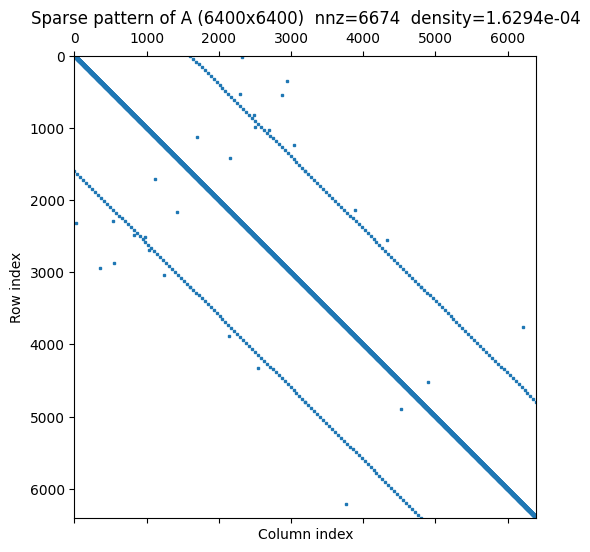

In [ ]:
# Heat map of sparse matrix A (value‑coded non‑zeros)

sparse_A = ham.A if hasattr(ham, "A") else A
if not ss.issparse(sparse_A):
    sparse_A = ss.csr_matrix(sparse_A)

m, n = sparse_A.shape
nnz = sparse_A.nnz
density = nnz / (m * n)

# For large sparse matrices avoid full densification; plot only non‑zeros with value colormap
coo = sparse_A.tocoo()

plt.figure(figsize=(6, 6))
sc = plt.scatter(coo.col, coo.row, c=coo.data, cmap='viridis', s=6, marker='s', linewidths=0)
plt.gca().invert_yaxis()
plt.colorbar(sc, label='Entry value')
plt.title(f"Heat map (non-zeros) of A ({m}x{n})  nnz={nnz}  density={density:.4e}")
plt.xlabel("Column index")
plt.ylabel("Row index")
plt.tight_layout()
plt.show()


In [5]:
ham.plot_hamiltonian()

AttributeError: 'SimpleHamiltonian' object has no attribute 'plot_hamiltonian'

In [5]:
metrics_df

,ghost_rate_metrics,clone_fraction_metrics,reconstruction_efficiency_metrics,hit_efficiency_metrics,purity_metrics,total_rec_tracks_metrics,total_truth_tracks_metrics,ghost_tracks_metrics,clones_count_metrics
0,0.000000,0.0,1.0000,1.000000,1.000000,80,80,[],0
1,0.000000,0.0,1.0000,1.000000,1.000000,80,80,[],0
2,0.000000,0.0,1.0000,1.000000,1.000000,80,80,[],0
3,0.000000,0.0,1.0000,1.000000,1.000000,80,80,[],0
4,0.000000,0.0,1.0000,1.000000,1.000000,80,80,[],0
...,...,...,...,...,...,...,...,...,...
76,0.000000,0.0,0.9250,0.712121,1.000000,74,80,[],0
77,0.000000,0.0,0.9250,0.683673,1.000000,74,80,[],0
78,0.012821,0.0,0.9625,0.732500,1.000000,78,80,[0],0
79,0.000000,0.0,0.9625,0.755051,1.000000,77,80,[],0


In [6]:
full = pd.concat([metrics_df, res.drop(columns=['metrics'])], axis=1)

In [7]:
# save metrics_df as a CSV
full.to_csv("metrics.csv", index=False)

In [ ]:
full

,ghost_rate_metrics,clone_fraction_metrics,reconstruction_efficiency_metrics,hit_efficiency_metrics,purity_metrics,total_rec_tracks_metrics,total_truth_tracks_metrics,ghost_tracks_metrics,clones_count_metrics,Hit_res,Multi_scatter,noise_rate,efficency_err,epsilon
0,0.000000,0.0,1.00,1.000000,1.000000,40,40,[],0,0,0,0,0.0,0.000001
1,0.000000,0.0,1.00,1.000000,1.000000,40,40,[],0,0,0,0,0.01,0.000001
2,0.000000,0.0,1.00,1.000000,1.000000,40,40,[],0,0,0,0,0.02,0.000001
3,0.025641,0.0,0.95,0.950000,1.000000,39,40,[17],0,0,0,0.001,0.0,0.000001
4,0.000000,0.0,1.00,1.000000,1.000000,40,40,[],0,0,0,0.001,0.01,0.000001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0.000000,0.0,1.00,1.000000,1.000000,40,40,[],0,0.004,0.0004,0.001,0.01,0.000002
77,0.025641,0.0,0.95,0.954082,1.000000,39,40,[8],0,0.004,0.0004,0.001,0.02,0.000002
78,0.000000,0.0,1.00,1.000000,1.000000,40,40,[],0,0.004,0.0004,0.01,0.0,0.000002
79,0.000000,0.0,1.00,1.000000,0.995833,40,40,[],0,0.004,0.0004,0.01,0.01,0.000002


In [ ]:
print(full.dtypes)

ghost_rate_metrics                   float64
clone_fraction_metrics               float64
reconstruction_efficiency_metrics    float64
hit_efficiency_metrics               float64
purity_metrics                       float64
total_rec_tracks_metrics               int64
total_truth_tracks_metrics             int64
ghost_tracks_metrics                  object
clones_count_metrics                   int64
Hit_res                               object
Multi_scatter                         object
noise_rate                            object
efficency_err                         object
epsilon                               object
dtype: object


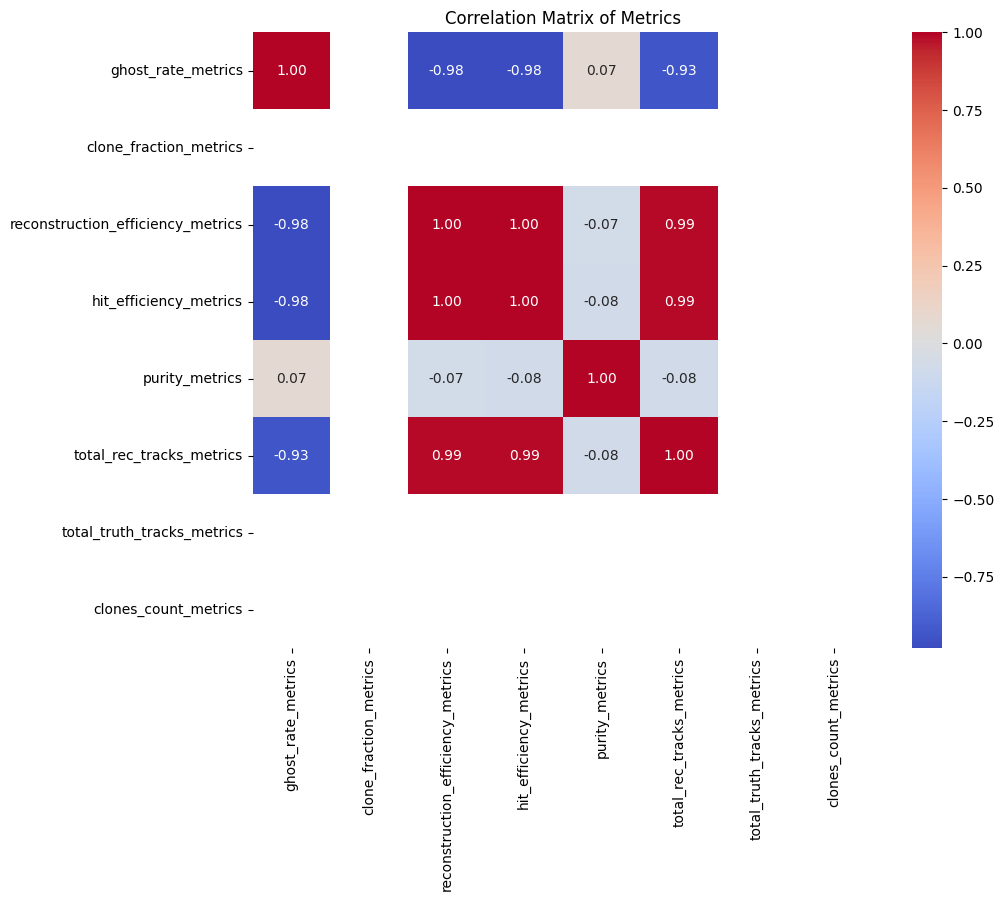

In [ ]:
import seaborn as sns

# Compute the correlation matrix for numeric columns only
corr = full.select_dtypes(include=['float64', 'int64','float32', 'int32']).corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Metrics")
plt.show()